# Udacity Data Wrangling Project 


## Table of Contents
<ul>
<li><a href="#objective">Objective</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
    <ul>
    <li><a href="#imports">Imports</a></li>
    <li><a href="#gather">Gathering The Data</a></li>
    <li><a href="#asses">Assessing The Data</a></li>
        <ul>
            <li><a href="#quality">Quality</a></li>
            <li><a href="#tidiness">Tidiness</a></li>
        </ul>
    <li><a href="#clean">Clean The Data</a></li>
        <ul>
            <li><a href="#missing">Missing Data</a></li>
            <li><a href="#clean_tidiness">Tidiness</a></li>
            <li><a href="#clean_quality">Quality</a></li>
    </ul>
<li><a href="#save_results">Save The Result Dataframes In a Database</a></li>       
<li><a href="#analyzing_data">Analyzing The Data</a></li>
    <ul>
    <li><a href="#analyzing_conversations">Analysis Of Conversations In The Replies</a></li>
    <li><a href="#analyzing_proportions">Analysis Of The Proportions Of Dogs Detected In The Pictures</a></li>
    <li><a href="#analyzing_replies">Analysis Of Replies Per User And Per Breed</a></li>
</ul>
        
        

<a id='objective'></a>
## Objective

In this project we are going to extract data from different sources related with the Twitter account `@dog_rates`.

Basicly we will work with four data sources:

* **'twitter-archive-enhanced.csv':**  A csv file with 2356 tweets of this account. Each one with a picture of a dog. They use to mark this dogs, usually with marks greater than 10 over 10: 11/10, 13/10, etc. This file is provided by Udacity for making the project.

* **'image-predictions.tsv':** A tsv file with the results obtained of applying a predictive method over the pictures of the tweets. This file was obtained in a project in another nanodegreee and it is provided by Udacity also. Every image in the WeRateDogs Twitter archive was run through a neural network that can classify breeds of dogs. The results: a table full of image predictions (the top three only) alongside each tweet ID, image URL, and the image number that corresponded to the most confident prediction (numbered 1 to 4 since tweets can have up to four images).

* **Additional information obtained with tweetpy:** Once obtained the Twitter credentials, we are going to use the tweetpy API to get more additional data. To do this we will connect to the Twitter platform and using tweetpy we will download the tweet status for each tweet in `twitter-archive-enhanced.csv`. Then we will save these results in a file called `twitter_archive.json` using the json library. Finally, we will read this file and we will extract some more data to another dataframe using json again.

* **Information abour the replies of each tweet:** Finally we would like to extract the data corresponding to the replies of each tweet. We have tried some different methods:

    * In some places it is recommended to use tweepy to make a query of all the tweets referenced to @rate_dogs, and search which of them are a reply to the status of the tweet. Translated to code, something like this:
    
            consumer_key = 'XXXXXX'
            consumer_secret = 'XXXXXX'
            access_token = 'XXXXXX'
            access_secret = 'XXXXXX'

            auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
            auth.set_access_token(access_token, access_secret)

            twapi = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)
    
            replies=[]

            for tweet in tweepy.Cursor(twapi.search,q='to:'+name, since_id=892420643555336193, result_type='recent',timeout=999999).items(1000)
                if hasattr(tweet, 'in_reply_to_status_id_str'):
                    if (tweet.in_reply_to_status_id_str==tweet_id):
                        replies.append(tweet)
            
      but it has a lot of limitations and I didn't like it too much.

    * In other places it is recommended to use the urllib3 library to request pages. Then, you can use BeautifulSoup to interpret the result and scrapp the information that you need:
    
             http = urllib3.PoolManager()
             url = "https://twitter.com/dog_rates/status/892420643555336193"
             r = http.request('GET', url)
             soup = BeautifulSoup(r.data)
             tweets = soup.find_all('li','js-stream-item')
             for tweet in tweets:

             full_name = tweet.find("span", "FullNameGroup").find("strong", "fullname").contents[0]  
        
      But, in this case, you need to make scroll down on the page to see all the replies. Even so, when there are too many replies, the page cut the list and ask you in a link if you want to see more. You had to do this as many times as you need until you reach the end of the list. Apart from that, sometimes there are replies to the replies, and the page has another link to select to see them. I mean that with a single request you can't see all the replies if these are a lot.
      Maybe yo can do that using additional requests with POST or some other commands and sending the correct instruction to click in all the necessary links. But I felt like it was too much complicated.
       
    * Finally, I tried another method to do scrapping. I used the `selenium` library. It permits you to use a local browser to open the pages. You can navigate using the program on these pages and select and click any element of the page. Once you have deployed completely the page you can get it to a beautifulsoup object and interpret it. And using a local browser can be viewed as a disadvantage, but I felt more comfortable with this method and it is what I have used.




<a id='wrangling'></a>
## Data Wrangling

<a id='imports'></a>
### Imports

In [1]:
#basic data libraries
import pandas as pd
import numpy as np
#to interact with the local system
import os
import sys
#to work with regular expressions
import re
#imports to user timers and make conversions of time formats
from timeit import default_timer as timer
from datetime import datetime
import time
#to make logs and track those processes that take a long time
import logging
#to get and interpret information of the web
import requests
import tweepy
from tweepy import OAuthHandler
import json
from bs4 import BeautifulSoup
import urllib.parse
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.common.exceptions import NoSuchElementException

#import for stats
import statsmodels.api as sm

#import sqlite3 library to connect to DBLite
import sqlite3

#networkx to see social graphos
import networkx as nx

#import Pillow to see images
from PIL import Image

#matplotlib to display plots
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D 
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context("talk")
plt.style.use('seaborn-deep')
%matplotlib inline
import warnings; warnings.simplefilter('ignore')


<a id='gather'></a>
### Gathering The Data

* The first step will be to define a function to connect to Twitter using the API `tweepy`. We will use this function in other cells below. 

In [2]:
def connect_twitter():
    '''
    It connects to Twitter API.
    
    Returns:
        twapi: tweepy.api object to interact with the page.
    '''
    
    #It reads the keys to connect to Twitter API from a local file.
    #These keys are hidden to comply with Twitter's API terms and conditions
    with open('API keys.txt', mode = 'r') as file:
        keys = file.readlines()
        
    keys = [x.strip() for x in keys] 
    
    consumer_key = keys[0].split(":")[1]
    consumer_secret = keys[1].split(":")[1]
    access_token = keys[2].split(":")[1]
    access_secret = keys[3].split(":")[1]
    
    #It authenticates in tweepy with the previous credentials.
    auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_secret)
    twapi = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)
    
    return twapi


* Create the folder where to save the necesary files.

In [3]:
#It creates a folder called resources if it does not exists
folder_name = 'resources'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)


* Load data from `twitter-archive-enhanced.csv` file supplied by Udacity. This dataframe has the following columns:

    - **tweet_id:** The integer representation of the unique identifier for this Tweet. 
    - **in_reply_to_status_id:** If the represented Tweet is a reply, this field will contain the integer representation of the original Tweet’s ID.
    - **in_reply_to_user_id:**  If the represented Tweet is a reply, this field will contain the integer representation of the original Tweet’s author ID. This will not necessarily always be the user directly mentioned in the Tweet.
    - **timestamp:** date and time of the tweet.
    - **source:** Utility used to post the Tweet, as an HTML-formatted string. Tweets from the Twitter website have a source value of web.
    - **text:** The actual UTF-8 text of the status update. 
    - **retweeted_status_id:** If the represented Tweet is a retweet, this field will contain the integer representation of the original Tweet’s ID. If it is a retweet of a retweet it containg the original message id.
    - **retweeted_status_user_id:**  If the represented Tweet is a retweet, this field will contain the integer representation of the original Tweet’s author ID. This will not necessarily always be the user directly mentioned in the Tweet.
    - **retweeted_status_timestamp:** If the represented Tweet is a retweet, the timestampo of the original tweet.
    - **expanded_urls:** url of the tweet.
    - **rating_numerator:** numerator of the rating assigned according to the text of the tweet.
    - **rating_denominator:** denominator of the rating assigned according to the text of the tweet.
    - **name:** name of the dog according to the text of the tweet.
    - **doggo:** type of the dog acording to the text and to the clasification used in the page.
    - **floofer:** type of the dog acording to the text and to the clasification used in the page.
    - **pupper:** type of the dog acording to the text and to the clasification used in the page.
    - **puppo:** type of the dog acording to the text and to the clasification used in the page. 
    
    
![alt text](dogtionary-combined.png)


In [4]:
#Load the file twitter-archive-enhanced.csv into a dataframe
df_twitter_archive_enhanced = pd.read_csv(os.path.join(folder_name, 'twitter-archive-enhanced.csv'))

* Load data from the `image-predictions.tsv` file. This file was provided by Udacity in a especified url.

In [5]:
#We donwload the image-predictions.tsv file from the expecified url.
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)
with open(os.path.join(folder_name, url.split('/')[-1]), mode = 'wb') as file:
        file.write(response.content)

* We crate a new dataframe called `df_image_predictions`. This dataframe has the following columns:

    - **tweet_id:** tweet_id is the last part of the tweet URL after "status/": `https://twitter.com/dog_rates/status/889531135344209921`
    
    - **jpg_url:** url of the image of the tweet. It can be downloaded.
    - **img_num:** the image with the most confident prediction.
    - **p1:** is the algorithm's #1 prediction for the image in the tweet.
    - **p1_conf:** is how confident the algorithm is in its #1 prediction.
    - **p1_dog:** is whether or not the #1 prediction is a breed of dog.
    - **p2:** is the algorithm's second most likely prediction.
    - **p2_conf:** is how confident the algorithm is in its #2 prediction.
    - **p2_dog:** is whether or not the #2 prediction is a breed of dog.
    - **p3:** is the algorithm's third most likely prediction.
    - **p3_conf:** is how confident the algorithm is in its #3 prediction.
    - **p3_dog:** is whether or not the #3 prediction is a breed of dog.

In [6]:
#Load the file image-predictions.tsv into the dataframe df_image_predictions
df_image_predictions = pd.read_csv(os.path.join(folder_name, 'image-predictions.tsv'), sep='\t')

* Load additional data from the pages of the tweets with the API tweepy. At the same time, we can see which pages still exist and which are not available in this moment. First, we download the content of the page of each tweet and we store it in a file calle `twitter_archive.json`, in json format.

In [7]:
=================================================
REMOVE THIS TO EXECUTE IT. IT CAN TAKES MORE THAN AN HOUR.
IF YOU DON`T EXECUTE IT THE PROGRAM CONTINUE WORKING WITH THE FILE twitter_archive.json
ALREADY DOWNLOAD IT
=================================================
#we connect to the Twitter API using tweepy 
twapi = connect_twitter()

start = timer()
#It configures the file 'tweepy_api.log' as a log to track the evolution
logging.basicConfig(filename='tweepy_api.log',level=logging.DEBUG)

#It initializes a list of Id's with all the tweets.
list_ids = df_twitter_archive_enhanced.tweet_id

total_count = 0
error_count = 0

#It initializes the log file
open('tweepy_api.log', 'w').close()

#It initializes the files used to save the results.
#We have created two files: one estructured in lines and other indented for a more
#friendly check.
open(os.path.join(folder_name, 'twitter_archive_indent.json'), 'w').close()
open(os.path.join(folder_name, 'twitter_archive.json'), 'w').close()

for tweet_id in list_ids:
    total_count += 1
    logging.debug('%s: Trying tweet for ID %s', total_count, tweet_id)
    try:
        #download the content of a tweet for a tweet_id given
        tweet = twapi.get_status(tweet_id, tweet_mode='extended')
        #store the content of the tweet using json in the file tweet_json_indent.txt, indent=2 spaces.
        with open(os.path.join(folder_name, 'twitter_archive_indent.json'), 'a', encoding='utf8', newline='\n') as out_file:
            json.dump(tweet._json, out_file, indent=2, ensure_ascii=False)
            out_file.write('\n')
        #store the content of the tweet using json in the file tweet_json.txt, in a sigle line.
        with open(os.path.join(folder_name, 'twitter_archive.json'), 'a', encoding='utf8', newline='\n') as out_file:
            json.dump(tweet._json, out_file, ensure_ascii=False)
            out_file.write('\n')
            
        #separate each tweet in the log file.    
        logging.debug('============================================================================')
        logging.debug('============================================================================')
    except tweepy.TweepError as te:
        #if we cannot download the tweet, we reflect this in the log and we increment the error count.
        logging.warning('%s: FAILED to get tweet ID %s: %s', total_count, tweet_id, str(te))
        error_count += 1
                    
    end = timer()
    #separate each tweet in the log file. 
    logging.debug('TOTAL: %s: TIME %s%s', total_count, end-start,'===========================================')
    logging.debug('TOTAL: %s. ERRORS: %s%s', total_count, error_count,'===========================================')
    logging.debug('============================================================================')
    logging.debug('============================================================================')
        


SyntaxError: invalid syntax (<ipython-input-7-a53d9b121c8f>, line 1)

* Total count of tweets in this new file and number of errors. The errors are pages that existed when Udacity extracted the file `twitter-archive-enhanced.csv`, but now are unavailable.

* Use the data stored in the file `twitter_archive.json` in the previous step to create a new dataframe called `df_tweepy_extractions`. This dataframe will have the following columns:

    - **tweet_id:** The integer representation of the unique identifier for this Tweet.
    - **entities_name:** Users who are labelled under the picture of the tweet.
    - **entities_screen_name:** Screen name of the users who are labelled under the picture of the tweet.
    - **entities_type:** The type of the entity. In this case is always 'user'
    - **entities_user_id:** ID of the users who are labelled under the picture of the tweet.
    - **favorite_count:**  Indicates approximately how many times this Tweet has been liked by Twitter users. 
    - **favorites_count_retweet:** This field only surfaces when the Tweet is a retweet. Indicates approximately how many times the original Tweet has been liked by Twitter users. 
    - **mentions_name:** Display name of the referenced user in the text of the tweet.
    - **mentions_screen_name:** Screen name of the referenced user in the text of the tweet.
    - **mentions_user_id:** ID of the user mentioned in the text of the tweet.
    - **quoted_status_id:** This field only surfaces when the Tweet is a quote Tweet. This field contains the integer value Tweet ID of the quoted Tweet. 
    - **quoted_user_id:** ID of the user quoted.
    - **quoted_status_id_rwetweet:** This field only surfaces when the Tweet is a retweet and the original Tweet is a is a quote Tweet. This field contains the integer value Tweet ID of the quoted Tweet.
    - **retweet_count:** Number of times this Tweet has been retweeted.
    - **retweet_count_retweet:** This field only surfaces when the Tweet is a retweet. Indicates approximately how many times the original Tweet has been retweeted.
    

In [8]:
#we first read the file and load the lines in a list called content
with open(os.path.join(folder_name, 'twitter_archive.json'), 'r', encoding='utf8') as input_file:
    content = input_file.readlines()
content = [x.strip() for x in content] 

#initialize the result dataframe df_tweepy_extractions
df_tweepy_extractions = pd.DataFrame()
tweet_status = {}

#read recursively each line in the list content
for line in content:
    #initialize the outcomes
    entities_name = ''
    entities_screen_name  = ''
    entities_type = ''
    entities_user_id = ''
    mentions_user_id = ''
    mentions_name = ''
    mentions_screen_name = ''
    favorites_count_retweet = 0
    retweet_count_retweet = 0
    quoted_status_id_rwetweet = ''
    quoted_status_id_str = ''
    quoted_user_id_str = ''
    quoted_user_id_retweet = ''
    
    #read each string with json.loads to interpretarte it
    tweet_status = json.loads(line)
    try:
        #if the object media exists innside entities.
        if 'media' in tweet_status['entities']:
            #In this case we are going to see the user or users tagged below the picture
            if 'all' in tweet_status['entities']['media'][0]['features']:
                #a list with the names of the users tagged
                entities_name = [name['name'] for name in tweet_status['entities']['media'][0]['features']['all']['tags']]
                #the screen names eje:@bla_bla_bla
                entities_screen_name = [screen_name['screen_name'] for screen_name in tweet_status['entities']['media'][0]['features']['all']['tags']]
                #types: user
                entities_type = [type_['type'] for type_ in tweet_status['entities']['media'][0]['features']['all']['tags']]
                #a list with the users id
                entities_user_id = [user_id['user_id'] for user_id in tweet_status['entities']['media'][0]['features']['all']['tags']]
        #if the object user_mentions exists innside entities. We can search the users named inside te text part.
        if 'user_mentions' in tweet_status['entities']:
            if len(tweet_status['entities']['user_mentions']) > 0:
                #the id of the user mentioned
                mentions_user_id = [user_id['id_str'] for user_id in tweet_status['entities']['user_mentions']]
                #the name of the user mentioned
                mentions_name = [name['name'] for name in tweet_status['entities']['user_mentions']]
                #the screen name of the user mentioned
                mentions_screen_name = [screen_name['name'] for screen_name in tweet_status['entities']['user_mentions']]
        #if the tweet is a retweet
        if 'retweeted_status' in tweet_status:
            if 'favorite_count' in tweet_status['retweeted_status']:
                #number of favorites in the original tweet.
                favorites_count_retweet = tweet_status['retweeted_status']['favorite_count']
                #number of retweets in the original tweet.
                retweet_count_retweet = tweet_status['retweeted_status']['retweet_count']
            if 'quoted_status_id_str' in tweet_status['retweeted_status']:
                #if the tweet is a retweet of a previously quoted tweet. The tweet id of the original quoted tweet.
                quoted_status_id_rwetweet = tweet_status['retweeted_status']['quoted_status_id_str']
                if 'quoted_status' in tweet_status['retweeted_status']:
                    #id of the user quoted.
                    quoted_user_id_retweet = tweet_status['retweeted_status']['quoted_status']['user']['id_str']
    
        #if the tweet is a quoted ot other tweet.
        if 'quoted_status_id_str' in tweet_status:
            #the id of the quoted tweet.
            quoted_status_id_str = tweet_status['quoted_status_id_str']
            if 'quoted_status' in tweet_status:
                #id of the user quoted.
                quoted_user_id_str = tweet_status['quoted_status']['user']['id_str']
    
    except Exception as e:
        #register in the log any exception that it can occurs.
        print(tweet_status['id_str'])
        logging.warning(e)
    #save the results in the dataframe df_tweepy_extractions
    df_tweepy_extractions = df_tweepy_extractions.append({'tweet_id': tweet_status['id_str'],
                                                          'retweet_count': tweet_status['retweet_count'],
                                                          'favorite_count': tweet_status['favorite_count'],
                                                          'favorites_count_retweet': favorites_count_retweet,
                                                          'retweet_count_retweet': retweet_count_retweet,
                                                          'entities_name': entities_name,
                                                          'entities_screen_name': entities_screen_name,
                                                          'entities_type': entities_type,
                                                          'entities_user_id': entities_user_id,
                                                          'mentions_user_id': mentions_user_id,
                                                          'mentions_name': mentions_name,
                                                          'mentions_screen_name': mentions_screen_name,
                                                          'quoted_status_id': quoted_status_id_str,
                                                          'quoted_user_id': quoted_user_id_str,
                                                          'quoted_status_id_rwetweet': quoted_status_id_rwetweet,
                                                          'quoted_user_id_retweet': quoted_user_id_retweet
                                                          },ignore_index=True)
    #It sorts the columns of the dataframe. 
    df_tweepy_extractions = df_tweepy_extractions[['tweet_id', 'retweet_count', 'favorite_count', 'favorites_count_retweet',
                                                 'retweet_count_retweet', 'entities_name', 'entities_screen_name', 
                                                 'entities_type', 'entities_user_id', 'mentions_user_id', 'mentions_name',
                                                 'mentions_screen_name', 'quoted_status_id', 'quoted_user_id', 
                                                 'quoted_status_id_rwetweet', 'quoted_user_id_retweet']]


In [9]:
df_tweepy_extractions.query('quoted_user_id_retweet != ""')

,tweet_id,retweet_count,favorite_count,favorites_count_retweet,retweet_count_retweet,entities_name,entities_screen_name,entities_type,entities_user_id,mentions_user_id,mentions_name,mentions_screen_name,quoted_status_id,quoted_user_id,quoted_status_id_rwetweet,quoted_user_id_retweet
31,886054160059072513,101.0,0.0,1482.0,101.0,,,,,[19607400],[Oakland A's],[Oakland A's],886053434075471873,,886053434075471873,4196983835


#### Scrapping Replies Using Selenium

* Finally we are going to sacrap more information about each tweet using the library selenium. We are interested into obtain information about all the replies for each tweet. We will get a final dataframe called `df_scrapped_replies` with the following columns:

    - **conversation:** Id of the replied tweet.
    - **favs:** Number of favorites for this replying tweet.
    - **full_name:** name of the user who has replied.
    - **image:** If there is an image in the reply, it especifies the url.
    - **language:** When present, indicates a BCP 47 language identifier corresponding to the machine-detected language of the Tweet text.
    - **references:** Other users ID that are referenced in the text of the reply, if they exist.
    - **replies:** Number of replies to this reply.
    - **reply_id:** tweet ID for this reply.
    - **retweets:** Number of retweets of this reply.
    - **text:** Text include in the reply.
    - **timestamp:** Date_time of the reply.
    - **user_id:** Id of the user who has replied.
    - **user_name:** Name of the user who has replied (@XXXXX).


* This fuction download a status page with all its replies into a driver object. We have user the Firefox driver.

In [10]:
def download_page(driver, user_name, conversation_id):

    '''
    This fuction download a status page with all its replies into a driver object. We have user the Firefox driver.
    
    Args:
        driver: selenium.webdriver object. Used to get the page, to move on it and make actions.
        (str) user_name: user name of the twitter profile. In this project: dog_rates.
        (str) conversation_id: status or tweet id for which we want to extract the data.
    
    Return:
    
        driver: selenium.webdriver object. The same object, but with all the replies to the tweet opened
    
    '''
    
    #Initialize a new file for the log.
    logging.basicConfig(filename='scrapping_replies.log',level=logging.DEBUG)
    #url of the page that we want to download
    url = "https://twitter.com/" + user_name + "/status/" + conversation_id
    #time to wait after each scroll
    SCROLL_PAUSE_TIME = 2
    # tells WebDriver to poll the DOM for a certain amount of time when trying 
    #to find any element (or elements) not immediately available.
    driver.implicitly_wait(10)
    
    driver.get(url)
    #we use the length of the page to know if we have downloaded the complete page.
    last_length = len(driver.page_source)
    
    count = 0
    while True:
        #scroolls down to the end of the page
        driver.find_element_by_tag_name("body").send_keys(Keys.END)
        time.sleep(SCROLL_PAUSE_TIME)
        #the page is actualized with more replies. We get the new length
        new_length = len(driver.page_source)
        count += 1
        if count == 6:
            count = 0
        #Even when we have reached the end we wait 4*two weconds, just in case the page is not complete downloaded
        if (new_length == last_length) & (count > 4):
            count = 0
            #When the page is completely downloaded and there are not more replies to show, 
            #we search for the le link 'show nore replies' and we click it.
            try:             
                button_more = driver.find_element_by_css_selector('.ThreadedConversation-showMoreThreadsButton.u-textUserColor')
                button_more.click()
            except (NoSuchElementException, AttributeError) as e:
                logging.warning(e)
                break
        #se set the old length equal to the new length to start again the scroll down process.
        last_length = new_length
    #When there are not more replies neither any 'Show nore replies' link.
    #We click in all the intermediate links 'x replies more'. Sometimes people replies to the replies and this other replies
    #are not always showed at first.
    try:
        links_replies = driver.find_elements_by_css_selector('.ThreadedConversation-moreRepliesLink')
        for link in links_replies:
            link.click()
    except (NoSuchElementException, AttributeError) as e:
        logging.warning(e)
    #return the driver object with the complete page.
    return driver

* This function searchs for information inside the page stored in driver and it saves the content in the dataframe `df_scrapping_replies`.

In [11]:
def analize_page(driver, conversation_id):
    
    '''
    It searchs for information inside the page stored in driver and it saves the content in the dataframe df_scrapping_replies.
    
    Args:
        driver: selenium.webdriver object. Used to get the page, to move on it and make actions.
        (str) conversation_id: status or tweet id for which we want to extract the data.
    
    Return:
    
        df_scrapping_replies: pandas.dataframe object with all the data gathered.
    '''
    
    #it configures the file for the log.
    logging.basicConfig(filename='scrapping_replies.log',level=logging.DEBUG)
    #it initializes the dataframe df_scrapping_replies
    df_scrapping_replies = pd.DataFrame()
    #call BeautifulSoup with the driver page to be decoded
    soup = BeautifulSoup(driver.page_source, "html.parser")
    #load the content in a list of replies
    tweets = soup.find_all('li','js-stream-item')

    for tweet in tweets:
        #analyze each reply one by one
        try:
            #the status id of the reply
            reply_id = tweet.get('data-item-id')
            full_name = ""
            #we get only the text part of the name. There is other parts like emojis.
            full_names = tweet.find("span", "FullNameGroup").find("strong", "fullname").contents
            for name in full_names:
                if isinstance(name,  str):
                    full_name = full_name + name
                    
            #the name with @
            user_name = tweet.find("span", "username").find("b").contents[0].strip()
            #the id of the user.
            user_id = tweet.find("div",class_=re.compile("^tweet js-stream-tweet")).get('data-user-id')
            logging.debug(user_id)
            #The number of replies to this reply, number ot retweets and faver of this reply.
            replies = tweet.find("span", id=re.compile("^profile-tweet-action-reply-count")).contents[0]
            retweets = tweet.find("span", id=re.compile("^profile-tweet-action-retweet-count")).contents[0]
            favs = tweet.find("span", id=re.compile("^profile-tweet-action-favorite-count")).contents[0]
            #The language of the message if it is configured.
            language = tweet.find("p", "TweetTextSize js-tweet-text tweet-text").get('lang')
            #In the text part we only get the str part. We discard emojis and other things.
            texts = tweet.find("p", "TweetTextSize js-tweet-text tweet-text").contents
            text = ""
            ref = ""
            image = ""
            for subtext in texts:
                if isinstance(subtext,  str):
                    text = text + subtext
            ref_aux = tweet.find_all("a", "pretty-link js-user-profile-link")
            #the other users id that are referred in the text of the reply
            for subref in ref_aux:
                subrefs = subref.get('data-user-id')
                ref.append(subrefs)
            #We try to find if there is some image attached. If it is so, we save the url of the picture.
            try:
                image = tweet.find("div", "AdaptiveMedia-photoContainer js-adaptive-photo").get('data-image-url') 
            except AttributeError as e:
                logging.warning(e)
            #we also get the date_time of the reply
            timestamp = tweet.find("small", "time").find("span", "_timestamp js-short-timestamp").get('data-time')
            timestamp = str(datetime.fromtimestamp(int(timestamp)))
            
            #se save all in the dataframe df_scrapping_replies 
            df_scrapping_replies = df_scrapping_replies.append({'timestamp': timestamp,
                                                                'conversation': conversation_id,
                                                                'reply_id': reply_id,
                                                                'full_name': full_name,
                                                                'user_name': '@' + user_name,
                                                                'user_id': user_id,
                                                                'image': image,
                                                                'replies': int(replies.split()[0].replace('.','')),
                                                                'retweets': int(retweets.split()[0].replace('.','')),
                                                                'favs': int(favs.split()[0].replace('.','')),
                                                                'text': text,
                                                                'language': language,
                                                                'references': ref
                                                                },ignore_index=True)

        except AttributeError as e:
            logging.warning(e)
    
    #It reurns df_scrapping_replies 
    return df_scrapping_replies
    

* We call the neccessary functions to make the scrap. As it takes a long time, each time that we search the replies of a tweet we save them in the csv file. Instead of saving the complete file at the end. If there were any problem we would have save the results until this moment.

In [12]:
=================================================
REMOVE THIS TO EXECUTE IT. IT CAN TAKES SEVERAL HOURS TO FINISH
IN MY PC ALMOST A DAY.
IF YOU DON`T EXECUTE IT, THE PROGRAM CONTINUE WORKING WITH THE DATA
ALREADY DOWNLOAD IT.
=================================================
start = timer()
#initialize the log file
open('scrapping_replies.log', 'w').close()
logging.basicConfig(filename='scrapping_replies.log',level=logging.DEBUG)

logging.debug("********************** CONNECTING DRIVER TO PAGE **********************")
#initialize the driver.
twapi = connect_twitter()
driver = webdriver.Firefox()
logging.debug("********************** CONNECTION DONE!!!! **********************")
user_name = 'dog_rates'
i = 1
try:
    #search for each tweet id in df_tweepy_extractions (the tweets that we know that are available in this moment)
    for tweet_id in df_tweepy_extractions['tweet_id']:
        #call the download_page function to download the complete page
        logging.debug("********************** START DOWNLOAD: " + tweet_id + "(" + str(i) + ")" + ' **********************')
        driver = download_page(driver, user_name, tweet_id)
        logging.debug("********************** END DOWNLOAD: " + tweet_id + "(" + str(i) + ")" + ' **********************')
        #call the analize_page function to extract a dataframe with the results
        logging.debug("********************** START ANALYSIS: " + tweet_id + "(" + str(i) + ")" + ' **********************')
        df_scrapping_replies = analize_page(driver, tweet_id)
        #The first time that we save the resutls in scrapped_replies.csv we open the file in write mode and we write a header.
        #The next times we open the file in append mode and we don't write the header.
        if i == 1:
            df_scrapping_replies.to_csv(os.path.join(folder_name, 'scrapped_replies.csv'), mode='w', encoding='utf-8', index=False)
        else:
            df_scrapping_replies.to_csv(os.path.join(folder_name, 'scrapped_replies.csv'), mode='a', encoding='utf-8', index=False, header = False)
        end = timer()
        #each time we save a result. we register in the log file the number of tweet_id analyzed and the time consumed.
        logging.debug("********************** END ANALYSIS: " + tweet_id + "(" + str(i) + ")" + str(start-end) + ' **********************')
        i += 1
except Exception as e:
    logging.warning(e)
finally:
    #close and disconnect the driver.
    driver.quit()


SyntaxError: invalid syntax (<ipython-input-12-12282aa78257>, line 1)

* We load the data saved in `scrapped_replies.csv` in the steps before to the dataframe `df_scrapped_replies`. We can see that there are 23 tweets with no replies. We have 2310 rows in df_scrapped_replies and 2333 in df_tweepy_extractions.

In [13]:
df_scrapped_replies = pd.read_csv(os.path.join(folder_name, 'scrapped_replies.csv'))
df_scrapped_replies.conversation.nunique()

2310

In [14]:
df_tweepy_extractions.shape

(2333, 16)

These are the list of tweets without any replies.

In [15]:
df_scrapped_replies.conversation = df_scrapped_replies.conversation.astype(str)
df_tweepy_extractions[~df_tweepy_extractions.tweet_id.isin(df_scrapped_replies.conversation)].tweet_id

1941    673350198937153538
2054    670833812859932673
2063    670803562457407488
2184    668627278264475648
2190    668567822092664832
2193    668537837512433665
2198    668480044826800133
2201    668291999406125056
2241    667538891197542400
2245    667517642048163840
2257    667393430834667520
2264    667177989038297088
2286    666804364988780544
2289    666776908487630848
2292    666691418707132416
2302    666418789513326592
2304    666407126856765440
2316    666102155909144576
2318    666094000022159362
2320    666073100786774016
2325    666055525042405380
2327    666050758794694657
2331    666029285002620928
Name: tweet_id, dtype: object

<a id='asses'></a>
## Assesing The Data

* `df_twitter_archive_enhanced`

In [16]:
df_twitter_archive_enhanced.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2077,670833812859932673,NaN,NaN,2015-11-29 05:16:59 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Jett. He is unimpressed by flower. 7/1...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/670833812...,7,10,Jett,None,None,None,None
2082,670815497391357952,NaN,NaN,2015-11-29 04:04:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Sage. He likes to burn shit. 10/10 htt...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/670815497...,10,10,Sage,None,None,None,None
1450,695816827381944320,NaN,NaN,2016-02-06 03:50:33 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here's a dog enjoying a sunset. 11/10 would tr...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/695816827...,11,10,None,None,None,None,None
933,753655901052166144,NaN,NaN,2016-07-14 18:22:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...","""The dogtor is in hahahaha no but seriously I'...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/753655901...,10,10,None,None,None,None,None
1672,682389078323662849,NaN,NaN,2015-12-31 02:33:29 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Brody. He's a Downton Abbey Falsetto. Add...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/682389078...,9,10,Brody,None,None,None,None


In [17]:
df_twitter_archive_enhanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [18]:
#Text for the retweeted tweets.
df_twitter_archive_enhanced.query('retweeted_status_id.notnull() == True').text

19      RT @dog_rates: This is Canela. She attempted s...
32      RT @Athletics: 12/10 #BATP https://t.co/WxwJmv...
36      RT @dog_rates: This is Lilly. She just paralle...
68      RT @dog_rates: This is Emmy. She was adopted t...
73      RT @dog_rates: Meet Shadow. In an attempt to r...
                              ...                        
1023    RT @dog_rates: This is Shaggy. He knows exactl...
1043    RT @dog_rates: Extremely intelligent dog here....
1242    RT @twitter: @dog_rates Awesome Tweet! 12/10. ...
2259    RT @dogratingrating: Exceptional talent. Origi...
2260    RT @dogratingrating: Unoriginal idea. Blatant ...
Name: text, Length: 181, dtype: object

In [19]:
#unique numerators and denominators.
df_twitter_archive_enhanced.rating_numerator.unique(), df_twitter_archive_enhanced.rating_denominator.unique()

(array([  13,   12,   14,    5,   17,   11,   10,  420,  666,    6,   15,
         182,  960,    0,   75,    7,   84,    9,   24,    8,    1,   27,
           3,    4,  165, 1776,  204,   50,   99,   80,   45,   60,   44,
         143,  121,   20,   26,    2,  144,   88], dtype=int64),
 array([ 10,   0,  15,  70,   7,  11, 150, 170,  20,  50,  90,  80,  40,
        130, 110,  16, 120,   2], dtype=int64))

In [20]:
#numerator when the denominator = 10
df_twitter_archive_enhanced.query('rating_denominator == 10').rating_numerator.unique()

array([  13,   12,   14,    5,   17,   11,   10,  420,  666,    6,   15,
        182,    0,   75,    7,    9,    8,    1,   27,    3,    4, 1776,
         26,    2], dtype=int64)

In [21]:
#names with length smaller than 4 chars
df_twitter_archive_enhanced.query('name.str.len() < 4').name.unique()

array(['Jax', 'Ted', 'Jim', 'Gus', 'Rey', 'a', 'Aja', 'Jed', 'Leo', 'Ken',
       'Max', 'Ava', 'Eli', 'Ash', 'not', 'Mia', 'one', 'Ike', 'Mo', 'Bo',
       'Tom', 'Alf', 'Sky', 'Tyr', 'Moe', 'Sam', 'Ito', 'Doc', 'mad',
       'Jay', 'Mya', 'an', 'O', 'Al', 'Lou', 'my', 'Eve', 'Dex', 'Ace',
       'Zoe', 'Blu', 'his', 'all', 'Sid', 'old', 'Ole', 'Bob', 'the',
       'Obi', 'by', 'Evy', 'Tug', 'Jeb', 'Dot', 'Mac', 'Ed', 'Taz', 'Cal',
       'JD', 'Pip', 'Amy', 'Gin', 'Edd', 'Ben', 'Dug', 'Jo', 'Ron', 'Stu'],
      dtype=object)

In [22]:
#text for dogs with name 'O'
df_twitter_archive_enhanced.query('name == "O"').text

775    This is O'Malley. That is how he sleeps. Doesn...
Name: text, dtype: object

In [23]:
#text for dogs with name 'by'
df_twitter_archive_enhanced.query('name == "by"').text

1724    This is by far the most coordinated series of ...
Name: text, dtype: object

In [24]:
#number of dogs for each clasification as "doggo", "floofer", "pupper" and "puppo"
df_twitter_archive_enhanced.doggo.replace('None', '', inplace=True)
df_twitter_archive_enhanced.floofer.replace('None', '', inplace=True)
df_twitter_archive_enhanced.pupper.replace('None', '', inplace=True)
df_twitter_archive_enhanced.puppo.replace('None', '', inplace=True)
df_twitter_archive_enhanced.groupby(["doggo", "floofer", "pupper", "puppo"]).size().reset_index().rename(columns={0: "count"})

,doggo,floofer,pupper,puppo,count
0,,,,,1976
1,,,,puppo,29
2,,,pupper,,245
3,,floofer,,,9
4,doggo,,,,83
5,doggo,,,puppo,1
6,doggo,,pupper,,12
7,doggo,floofer,,,1


* `df_image_predictions`

In [25]:
df_image_predictions.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
438,674422304705744896,https://pbs.twimg.com/media/CVwHgblWcAACWOD.jpg,1,golden_retriever,0.964497,True,Labrador_retriever,0.009006,True,tennis_ball,0.007139,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
370,672975131468300288,https://pbs.twimg.com/media/CVbjRSIWsAElw2s.jpg,1,pug,0.836421,True,Brabancon_griffon,0.044668,True,French_bulldog,0.036570,True
965,706265994973601792,https://pbs.twimg.com/media/Cc0pLU0WAAEfGEw.jpg,1,papillon,0.743715,True,Pekinese,0.114042,True,Saint_Bernard,0.047715,True
678,683498322573824003,https://pbs.twimg.com/media/CXxGGOsUwAAr62n.jpg,1,Airedale,0.945362,True,Irish_terrier,0.026850,True,Lakeland_terrier,0.016826,True


In [26]:
df_image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [27]:
#tweets that have not been predicted as a dog in any of the three predictions.
df_image_predictions.query('p1_dog == False & p2_dog == False & p3_dog == False')[['img_num',
                                                                                   'tweet_id',
                                                                                   'p1','p1_dog',
                                                                                   'p2','p2_dog',
                                                                                   'p3','p3_dog']]

,img_num,tweet_id,p1,p1_dog,p2,p2_dog,p3,p3_dog
6,1,666051853826850816,box_turtle,False,mud_turtle,False,terrapin,False
17,1,666104133288665088,hen,False,cock,False,partridge,False
18,1,666268910803644416,desktop_computer,False,desk,False,bookcase,False
21,1,666293911632134144,three-toed_sloth,False,otter,False,great_grey_owl,False
25,1,666362758909284353,guinea_pig,False,skunk,False,hamster,False
...,...,...,...,...,...,...,...,...
2021,1,880935762899988482,street_sign,False,umbrella,False,traffic_light,False
2022,1,881268444196462592,tusker,False,Indian_elephant,False,ibex,False
2046,1,886680336477933568,convertible,False,sports_car,False,car_wheel,False
2052,1,887517139158093824,limousine,False,tow_truck,False,shopping_cart,False


* `df_tweepy_extractions`

In [28]:
df_tweepy_extractions.sample(10)

,tweet_id,retweet_count,favorite_count,favorites_count_retweet,retweet_count_retweet,entities_name,entities_screen_name,entities_type,entities_user_id,mentions_user_id,mentions_name,mentions_screen_name,quoted_status_id,quoted_user_id,quoted_status_id_rwetweet,quoted_user_id_retweet
24,887101392804085760,5546.0,29233.0,0.0,0.0,[Varun ks],[kvarun70],[user],[200387323],,,,,,,
1945,673320132811366400,7789.0,13309.0,0.0,0.0,,,,,,,,,,,
787,771908950375665664,1971.0,6801.0,0.0,0.0,,,,,,,,771905568600719360,7309052,,
2019,671538301157904385,389.0,918.0,0.0,0.0,,,,,,,,,,,
241,844979544864018432,2587.0,13803.0,0.0,0.0,[Bromoish],[Bromoish],[user],[1654585453],,,,,,,
385,824663926340194305,1800.0,10396.0,0.0,0.0,[Alice Moran],[Alice_Moran],[user],[44141752],,,,,,,
1399,698195409219559425,6084.0,17060.0,0.0,0.0,[Heidi Anderson],[Splendamomma],[user],[538278235],,,,,,,
588,798340744599797760,3520.0,0.0,12395.0,3520.0,[Amy],[amookietookie],[user],[2305655408],[4196983835],[WeRateDogs®],[WeRateDogs®],,,,
618,793500921481273345,2488.0,11145.0,0.0,0.0,,,,,,,,,,,
749,777621514455814149,2588.0,9080.0,0.0,0.0,[plain jane],[LisaBaller],[user],[228198012],,,,,,,


In [29]:
df_tweepy_extractions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2333 entries, 0 to 2332
Data columns (total 16 columns):
tweet_id                     2333 non-null object
retweet_count                2333 non-null float64
favorite_count               2333 non-null float64
favorites_count_retweet      2333 non-null float64
retweet_count_retweet        2333 non-null float64
entities_name                2333 non-null object
entities_screen_name         2333 non-null object
entities_type                2333 non-null object
entities_user_id             2333 non-null object
mentions_user_id             2333 non-null object
mentions_name                2333 non-null object
mentions_screen_name         2333 non-null object
quoted_status_id             2333 non-null object
quoted_user_id               2333 non-null object
quoted_status_id_rwetweet    2333 non-null object
quoted_user_id_retweet       2333 non-null object
dtypes: float64(4), object(12)
memory usage: 291.8+ KB


In [30]:
df_tweepy_extractions.query('quoted_user_id != ""') 

,tweet_id,retweet_count,favorite_count,favorites_count_retweet,retweet_count_retweet,entities_name,entities_screen_name,entities_type,entities_user_id,mentions_user_id,mentions_name,mentions_screen_name,quoted_status_id,quoted_user_id,quoted_status_id_rwetweet,quoted_user_id_retweet
41,884247878851493888,18980.0,69672.0,0.0,0.0,,,,,,,,883965650754039809,3097795571,,
71,878604707211726852,6678.0,28880.0,0.0,0.0,,,,,,,,878599868507402241,742143,,
82,876537666061221889,4376.0,22588.0,0.0,0.0,,,,,,,,876162994446753793,507967020,,
87,875097192612077568,5694.0,26314.0,0.0,0.0,,,,,,,,874413398133547008,21357526,,
106,871102520638267392,5209.0,20174.0,0.0,0.0,,,,,,,,871075758080503809,2745835322,,
127,866720684873056260,4588.0,19450.0,0.0,0.0,,,,,,,,866458718883467265,14173315,,
184,855818117272018944,5332.0,26359.0,0.0,0.0,,,,,,,,855656431005061120,184136149,,
232,846505985330044928,3088.0,14241.0,0.0,0.0,,,,,,,,846484798663245829,264924050,,
234,846139713627017216,10079.0,31307.0,0.0,0.0,,,,,,,,846088479142531073,2319349099,,
257,841320156043304961,5579.0,20097.0,0.0,0.0,,,,,,,,841311395547250688,28785486,,


In [31]:
df_tweepy_extractions.query('retweet_count_retweet != ""').shape

(2333, 16)

* `df_scrapped_replies`

In [32]:
df_scrapped_replies.sample(10)

,conversation,favs,full_name,image,language,references,replies,reply_id,retweets,text,timestamp,user_id,user_name
31476,807010152071229440,1.0,beth,NaN,und,"['4196983835', '30898396']",0.0,807750781533298689,0.0,NaN,2016-12-11 01:56:08,2920247805,@bethgaskell3
27354,816829038950027264,0.0,James Beales,NaN,en,"['111857177', '4196983835']",0.0,791474837000638464,0.0,it all makes sense now,2016-10-27 05:01:20,367543916,@BealesJames
20554,832215909146226688,0.0,Jacob Sewell,NaN,en,['4196983835'],0.0,832229340591091714,0.0,"9.75?! Brent, is that you?\r\n\r\nOr is this t...",2017-02-16 15:05:11,64851807,@digitalbusker
37048,792883833364439040,1.0,lau,NaN,en,"['3298704082', '4196983835', '612843995']",1.0,792884815221624832,0.0,it's just a thing they do as a joke idk it's cure,2016-10-31 01:24:05,3077749656,@Iaubunny
418,891815181378084864,0.0,Edgar Allen Qrow,NaN,en,"['4196983835', '194404177']",0.0,891815413885153282,0.0,Doggo does a sneak and scare. H*eck his pray. ...,2017-07-31 02:18:58,891062085823721474,@CNKWildCard
11637,870374049280663552,132.0,Garet,NaN,en,"['91408884', '180242824']",2.0,870464722549821441,0.0,I seriously love when people feel the need to ...,2017-06-02 04:18:56,170939476,@garetmckinley
48497,742465774154047488,1.0,movember,NaN,und,['4196983835'],1.0,742583777738645504,0.0,NaN,2016-06-14 07:05:43,855469406,@volleymollie
58829,692187005137076224,1.0,MindynMe,NaN,en,['4196983835'],0.0,692298396900708352,0.0,Need to hug that frown off that puppers face!,2016-01-27 11:49:34,4517042720,@MindynMe
59932,689154315265683456,1.0,goulcher,NaN,tl,['187513087'],0.0,689155030109257728,0.0,hahahaha,2016-01-18 19:38:57,18638542,@goulcher
15283,847251039262605312,9.0,Mark Shatraw,NaN,en,['4196983835'],0.0,847253536664559617,0.0,Make sure your book has a taxonomy of zooms,2017-03-30 03:05:59,21815273,@09mshatraw


In [33]:
df_scrapped_replies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72909 entries, 0 to 72908
Data columns (total 13 columns):
conversation    72909 non-null object
favs            72909 non-null float64
full_name       72456 non-null object
image           3864 non-null object
language        72909 non-null object
references      72909 non-null object
replies         72909 non-null float64
reply_id        72909 non-null int64
retweets        72909 non-null float64
text            65534 non-null object
timestamp       72909 non-null object
user_id         72909 non-null int64
user_name       72909 non-null object
dtypes: float64(3), int64(2), object(8)
memory usage: 7.2+ MB


<a id='quality'></a>
#### Quality

##### `df_twitter_archive_enhanced` table:

- Some tweets are not available now. 
- The type of the columns `tweet_id`, `in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_user_id` should be string.
- We are not intereste in the first par of the text (RT @XXXX:) when the tweet is a retweet. I already have this information in other columns.
- There are 23 rows with rating_denominator different to 10.
- And many rows have a numerator not very realistic.
- The name of the dogs `a`, `O`, `by`, `an`, `the`, `his`, `all`and `my` are incorrect. (We are not going to correct this by the moment. We do not need them)
- There are not many dogs classified as doggo, floofer, etc. And 14 of them have double clasification.
- We would like to know the number of replies to each tweet.


##### `df_image_predictions` table:

- The type of the column `tweet_id` should be string.


##### `df_tweepy_extractions` table:

- The column `retweet_count_retweet` has no sense because it has the same value as `retweet_count`.
- we don't need the columns `entities_name`, `entities_screen_name`, `entities_type`, `mentions_name` and `mentions_screen_name` because we are going to use only the ids, so we can drop them by now.
- Nulls represented as void strings in `entities_name`,	`entities_screen_name`, `entities_type`, `entities_user_id`,	`entions_name`,	`mentions_screen_name`,	`mentions_user_id`,	`quoted_status_id`,	`quoted_status_id_rwetweet` and `retweet_count_retweet`.


##### `df_scrapped_replies` table:

- we don't need the columns `user_name` and `full_name` because we are goin to user only the id.
- The type of the columns `favs`, `replies` and `retweets` should be integer instead of float.
- The type of the columns `user_id` and `reply_id` should be a string.
- `language` type should be categorical.
	




<a id='tidiness'></a>
#### Tidiness

##### `df_twitter_archive_enhanced` table:

- Columns `doggo`, `floofer`, `pupper` and `puppo` should be a unique column called dog_type.


##### `df_image_predictions` table:

- this dataframe should be integrated in df_twitter_archive_enhanced.

##### `df_tweepy_extractions` table:

- this dataframe should be integrated in df_twitter_archive_enhanced.

##### `df_scrapped_replies` table:


##### `df_twitter_archive_enhanced` and `df_scrapped_replies` 

- We want mentions, replies, retweets, quoted, etc grouped apart as a different kind of information. We can drop this columns in the original dataframes. We will do this at the end of the clean work.


<a id='clean'></a>
## Clean

In [34]:
#make a copy of all dataframes
df_twitter_archive_enhanced_copy = df_twitter_archive_enhanced.copy()
df_image_predictions_copy = df_image_predictions.copy()
df_tweepy_extractions_copy = df_tweepy_extractions.copy()
df_scrapped_replies_copy = df_scrapped_replies.copy()

<a id='missing'></a>
### Missing Data

#### `df_twitter_archive_enhanced`: Some tweets are not available now.

##### Define
Delete all rows whose tweet_id are not present in df_tweepy_extractions.

##### Code

In [35]:
df_twitter_archive_enhanced_copy[~df_twitter_archive_enhanced_copy.tweet_id.isin(df_tweepy_extractions_copy.tweet_id)].shape

(23, 17)

In [36]:
df_twitter_archive_enhanced_copy = df_twitter_archive_enhanced_copy[df_twitter_archive_enhanced_copy.tweet_id.isin(df_tweepy_extractions_copy.tweet_id)]

##### Test

In [37]:
df_twitter_archive_enhanced_copy[~df_twitter_archive_enhanced_copy.tweet_id.isin(df_tweepy_extractions_copy.tweet_id)].shape

(0, 17)

#### `df_twitter_archive_enhanced`: There are not many dogs classified as doggo, floofer, etc. And 14 of them have double clasification.

##### Define
-Try to improve this data wiht information from the comments in the replies. Maybe the most commented category in the text of df_scrapped_replies_copy can give us an oppinion about this clasification. Define a new column `type_of_dog` with this iformation.


##### Code

In [38]:
#new dataframe df_type_of_dog
df_type_of_dog = pd.DataFrame()
df_type_of_dog['conversation'] = df_scrapped_replies_copy.conversation.astype(str)
#count the times that the words doggo, floofer, etc, appear in each reply
df_type_of_dog['doggo'] = df_scrapped_replies_copy.text.str.count("doggo")
df_type_of_dog['floofer'] = df_scrapped_replies_copy.text.str.count("floofer")
df_type_of_dog['pupper'] = df_scrapped_replies_copy.text.str.count("pupper")
df_type_of_dog['puppo'] = df_scrapped_replies_copy.text.str.count("puppo")
#sum the number of words by conversation
df_type_of_dog = df_type_of_dog.groupby('conversation').sum()
#delete the rows with all 0's
df_type_of_dog = df_type_of_dog.query('(doggo == floofer == pupper == puppo == 0) == False')
#put the type with the maximum value in the column 'type'.
df_type_of_dog['type_of_dog'] = df_type_of_dog[["doggo", "floofer", "pupper", "puppo"]].idxmax(axis=1)
#drop the rest of the columns
df_type_of_dog = df_type_of_dog.drop(columns=['doggo', 'floofer', 'pupper', 'puppo'])
df_type_of_dog = df_type_of_dog.reset_index()


In [39]:
df_twitter_archive_enhanced_copy['tweet_id'] = df_twitter_archive_enhanced_copy['tweet_id'].astype(str)
#merge df_type_of_dog and df_twitter_archive_enhanced_copy
df_twitter_archive_enhanced_copy = df_twitter_archive_enhanced_copy.merge(df_type_of_dog, 
                                                                          left_on='tweet_id', 
                                                                          right_on='conversation', 
                                                                          how = 'left')
#drop the column conversation from df_twitter_archive_enhanced_copy
df_twitter_archive_enhanced_copy.drop(columns = ['conversation'], inplace = True)

##### Test

In [40]:
df_twitter_archive_enhanced_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2333 entries, 0 to 2332
Data columns (total 18 columns):
tweet_id                      2333 non-null object
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2333 non-null object
source                        2333 non-null object
text                          2333 non-null object
retweeted_status_id           165 non-null float64
retweeted_status_user_id      165 non-null float64
retweeted_status_timestamp    165 non-null object
expanded_urls                 2274 non-null object
rating_numerator              2333 non-null int64
rating_denominator            2333 non-null int64
name                          2333 non-null object
doggo                         2333 non-null object
floofer                       2333 non-null object
pupper                        2333 non-null object
puppo                         2333 non-null object
type_of_dog                   1

#### `df_twitter_archive_enhanced` There are 23 rows with rating_denominator different to 10.

##### Define
Check the text of the tweets where the denominator is not 10.

Put the correct value in the row rating_denominator if it is possible.
It seems that many of them are correct. It uses to put denominatpor greater than 10 when there are various dogs. But many other are incorrect.

##### Code

In [41]:
df_twitter_archive_enhanced_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2333 entries, 0 to 2332
Data columns (total 18 columns):
tweet_id                      2333 non-null object
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2333 non-null object
source                        2333 non-null object
text                          2333 non-null object
retweeted_status_id           165 non-null float64
retweeted_status_user_id      165 non-null float64
retweeted_status_timestamp    165 non-null object
expanded_urls                 2274 non-null object
rating_numerator              2333 non-null int64
rating_denominator            2333 non-null int64
name                          2333 non-null object
doggo                         2333 non-null object
floofer                       2333 non-null object
pupper                        2333 non-null object
puppo                         2333 non-null object
type_of_dog                   1

In [42]:
df_twitter_archive_enhanced_copy.query('rating_denominator != 10').tweet_id.count()

22

In [43]:
df_twitter_archive_enhanced_copy.query('rating_denominator != 10')[['tweet_id','text', 'rating_numerator','rating_denominator']]

,tweet_id,text,rating_numerator,rating_denominator
299,835246439529840640,@jonnysun @Lin_Manuel ok jomny I know you're e...,960,0
328,832088576586297345,@docmisterio account started on 11/15/15,11,15
417,820690176645140481,The floofs have been released I repeat the flo...,84,70
499,810984652412424192,Meet Sam. She smiles 24/7 &amp; secretly aspir...,24,7
881,758467244762497024,Why does this never happen at my front door......,165,150
1046,740373189193256964,"After so many requests, this is Bretagne. She ...",9,11
1098,731156023742988288,Say hello to this unbelievably well behaved sq...,204,170
1143,722974582966214656,Happy 4/20 from the squad! 13/10 for all https...,4,20
1180,716439118184652801,This is Bluebert. He just saw that both #Final...,50,50
1206,713900603437621249,Happy Saturday here's 9 puppers on a bench. 99...,99,90


In [44]:
#835246439529840640: It is not the real rank
df_twitter_archive_enhanced_copy.loc[df_twitter_archive_enhanced_copy['tweet_id']
                                     ==835246439529840640, ['rating_numerator']] = 13
df_twitter_archive_enhanced_copy.loc[df_twitter_archive_enhanced_copy['tweet_id']
                                     ==835246439529840640, ['rating_denominator']] = 10
#832088576586297345: It has no rank
df_twitter_archive_enhanced_copy.loc[df_twitter_archive_enhanced_copy['tweet_id']
                                     ==832088576586297345, ['rating_numerator']] = np.NaN
df_twitter_archive_enhanced_copy.loc[df_twitter_archive_enhanced_copy['tweet_id']
                                     ==832088576586297345, ['rating_denominator']] = np.NaN
#820690176645140481: 84/70 It is correct.

#810984652412424192: It has no rank
df_twitter_archive_enhanced_copy.loc[df_twitter_archive_enhanced_copy['tweet_id']
                                     ==810984652412424192, ['rating_numerator']] = np.NaN
df_twitter_archive_enhanced_copy.loc[df_twitter_archive_enhanced_copy['tweet_id']
                                     ==810984652412424192, ['rating_denominator']] = np.NaN
#775096608509886464: It is correct.

#740373189193256964: It is not the real rank
df_twitter_archive_enhanced_copy.loc[df_twitter_archive_enhanced_copy['tweet_id']
                                     ==740373189193256964, ['rating_numerator']] = 14
df_twitter_archive_enhanced_copy.loc[df_twitter_archive_enhanced_copy['tweet_id']
                                     ==740373189193256964, ['rating_denominator']] = 10
#731156023742988288: It is correct.

#722974582966214656: It is not the real rank
df_twitter_archive_enhanced_copy.loc[df_twitter_archive_enhanced_copy['tweet_id']
                                     ==722974582966214656, ['rating_numerator']] = 13
df_twitter_archive_enhanced_copy.loc[df_twitter_archive_enhanced_copy['tweet_id']
                                     ==722974582966214656, ['rating_denominator']] = 10

#716439118184652801: It is not the real rank
df_twitter_archive_enhanced_copy.loc[df_twitter_archive_enhanced_copy['tweet_id']
                                     ==716439118184652801, ['rating_numerator']] = 11
df_twitter_archive_enhanced_copy.loc[df_twitter_archive_enhanced_copy['tweet_id']
                                     ==716439118184652801, ['rating_denominator']] = 10

#713900603437621249: It is correct.
#710658690886586372: It is correct.
#709198395643068416: It is correct.
#704054845121142784: It is correct.
#697463031882764288: It is correct.
#686035780142297088: It has no rank
df_twitter_archive_enhanced_copy.loc[df_twitter_archive_enhanced_copy['tweet_id']
                                     ==686035780142297088, ['rating_numerator']] = np.NaN
df_twitter_archive_enhanced_copy.loc[df_twitter_archive_enhanced_copy['tweet_id']
                                     ==686035780142297088, ['rating_denominator']] = np.NaN
#684225744407494656: It is correct.
#684222868335505415: It is correct.
#682962037429899265: It is not the real rank
df_twitter_archive_enhanced_copy.loc[df_twitter_archive_enhanced_copy['tweet_id']
                                     ==682962037429899265, ['rating_numerator']] = 10
df_twitter_archive_enhanced_copy.loc[df_twitter_archive_enhanced_copy['tweet_id']
                                     ==682962037429899265, ['rating_denominator']] = 10
#682808988178739200: It has no rank
df_twitter_archive_enhanced_copy.loc[df_twitter_archive_enhanced_copy['tweet_id']
                                     ==682808988178739200, ['rating_numerator']] = np.NaN
df_twitter_archive_enhanced_copy.loc[df_twitter_archive_enhanced_copy['tweet_id']
                                     ==682808988178739200, ['rating_denominator']] = np.NaN
#677716515794329600: It is correct.
#675853064436391936: It is correct.
#666287406224695296: It is not the real rank
df_twitter_archive_enhanced_copy.loc[df_twitter_archive_enhanced_copy['tweet_id']
                                     ==666287406224695296, ['rating_numerator']] = 9
df_twitter_archive_enhanced_copy.loc[df_twitter_archive_enhanced_copy['tweet_id']
                                     ==666287406224695296, ['rating_denominator']] = 10

##### Test

In [45]:
df_twitter_archive_enhanced_copy.query('rating_denominator != 10')[['tweet_id','text', 'rating_numerator','rating_denominator']]

,tweet_id,text,rating_numerator,rating_denominator
299,835246439529840640,@jonnysun @Lin_Manuel ok jomny I know you're e...,960.0,0.0
328,832088576586297345,@docmisterio account started on 11/15/15,11.0,15.0
417,820690176645140481,The floofs have been released I repeat the flo...,84.0,70.0
499,810984652412424192,Meet Sam. She smiles 24/7 &amp; secretly aspir...,24.0,7.0
881,758467244762497024,Why does this never happen at my front door......,165.0,150.0
1046,740373189193256964,"After so many requests, this is Bretagne. She ...",9.0,11.0
1098,731156023742988288,Say hello to this unbelievably well behaved sq...,204.0,170.0
1143,722974582966214656,Happy 4/20 from the squad! 13/10 for all https...,4.0,20.0
1180,716439118184652801,This is Bluebert. He just saw that both #Final...,50.0,50.0
1206,713900603437621249,Happy Saturday here's 9 puppers on a bench. 99...,99.0,90.0


#### `df_twitter_archive_enhanced` Many rows have a rating_numerator not very realistic.

##### Define
Check the rows with a denominator greater than 20 and confirm that are true.

##### Code

In [46]:
df_twitter_archive_enhanced_copy.query('rating_numerator > 20')[['tweet_id','text', 'rating_numerator','rating_denominator']]

,tweet_id,text,rating_numerator,rating_denominator
180,855862651834028034,@dhmontgomery We also gave snoop dogg a 420/10...,420.0,10.0
181,855860136149123072,@s8n You tried very hard to portray this good ...,666.0,10.0
278,838150277551247360,@markhoppus 182/10,182.0,10.0
299,835246439529840640,@jonnysun @Lin_Manuel ok jomny I know you're e...,960.0,0.0
326,832215909146226688,"RT @dog_rates: This is Logan, the Chow who liv...",75.0,10.0
417,820690176645140481,The floofs have been released I repeat the flo...,84.0,70.0
499,810984652412424192,Meet Sam. She smiles 24/7 &amp; secretly aspir...,24.0,7.0
677,786709082849828864,"This is Logan, the Chow who lived. He solemnly...",75.0,10.0
744,778027034220126208,This is Sophie. She's a Jubilant Bush Pupper. ...,27.0,10.0
881,758467244762497024,Why does this never happen at my front door......,165.0,150.0


In [47]:
#855862651834028034: It has no rank
df_twitter_archive_enhanced_copy.loc[df_twitter_archive_enhanced_copy['tweet_id']
                                     ==855862651834028034, ['rating_numerator']] = np.NaN
df_twitter_archive_enhanced_copy.loc[df_twitter_archive_enhanced_copy['tweet_id']
                                     ==855862651834028034, ['rating_denominator']] = np.NaN
#855860136149123072: It is a joke (666)
df_twitter_archive_enhanced_copy.loc[df_twitter_archive_enhanced_copy['tweet_id']
                                     ==855860136149123072, ['rating_numerator']] = np.NaN
df_twitter_archive_enhanced_copy.loc[df_twitter_archive_enhanced_copy['tweet_id']
                                     ==855860136149123072, ['rating_denominator']] = np.NaN
#838150277551247360: It has no rank
df_twitter_archive_enhanced_copy.loc[df_twitter_archive_enhanced_copy['tweet_id']
                                     ==838150277551247360, ['rating_numerator']] = np.NaN
df_twitter_archive_enhanced_copy.loc[df_twitter_archive_enhanced_copy['tweet_id']
                                     ==838150277551247360, ['rating_denominator']] = np.NaN
#832215909146226688: It is not correct.
df_twitter_archive_enhanced_copy.loc[df_twitter_archive_enhanced_copy['tweet_id']
                                     ==832215909146226688, ['rating_numerator']] = 9.75
df_twitter_archive_enhanced_copy.loc[df_twitter_archive_enhanced_copy['tweet_id']
                                     ==832215909146226688, ['rating_denominator']] = 10
#786709082849828864: It is not correct.
df_twitter_archive_enhanced_copy.loc[df_twitter_archive_enhanced_copy['tweet_id']
                                     ==786709082849828864, ['rating_numerator']] = 9.75
df_twitter_archive_enhanced_copy.loc[df_twitter_archive_enhanced_copy['tweet_id']
                                     ==786709082849828864, ['rating_denominator']] = 10
#778027034220126208: It is not correct.
df_twitter_archive_enhanced_copy.loc[df_twitter_archive_enhanced_copy['tweet_id']
                                     ==778027034220126208, ['rating_numerator']] = 11.27
df_twitter_archive_enhanced_copy.loc[df_twitter_archive_enhanced_copy['tweet_id']
                                     ==778027034220126208, ['rating_denominator']] = 10
#758467244762497024: It is correct.
#749981277374128128: It is correct, but a joke.
df_twitter_archive_enhanced_copy.loc[df_twitter_archive_enhanced_copy['tweet_id']
                                     ==749981277374128128, ['rating_numerator']] = np.NaN
df_twitter_archive_enhanced_copy.loc[df_twitter_archive_enhanced_copy['tweet_id']
                                     ==749981277374128128, ['rating_denominator']] = np.NaN
#731156023742988288: It is correct.
#713900603437621249: It is correct.
#710658690886586372: It is correct.
#709198395643068416: It is correct.
#704054845121142784: It is correct.
#697463031882764288: It is correct.
#684225744407494656 It is correct, but a joke.
df_twitter_archive_enhanced_copy.loc[df_twitter_archive_enhanced_copy['tweet_id']
                                     ==684225744407494656, ['rating_numerator']] = np.NaN
df_twitter_archive_enhanced_copy.loc[df_twitter_archive_enhanced_copy['tweet_id']
                                     ==684225744407494656, ['rating_denominator']] = np.NaN
#684222868335505415: It is correct.
#680494726643068929: It is not correct.
df_twitter_archive_enhanced_copy.loc[df_twitter_archive_enhanced_copy['tweet_id']
                                     ==680494726643068929, ['rating_numerator']] = 11.26
df_twitter_archive_enhanced_copy.loc[df_twitter_archive_enhanced_copy['tweet_id']
                                     ==680494726643068929, ['rating_denominator']] = 10
#677716515794329600: It is correct.
#675853064436391936: It is correct.
#670842764863651840:It is but a joke.
df_twitter_archive_enhanced_copy.loc[df_twitter_archive_enhanced_copy['tweet_id']
                                     ==670842764863651840, ['rating_numerator']] = np.NaN
df_twitter_archive_enhanced_copy.loc[df_twitter_archive_enhanced_copy['tweet_id']
                                     ==670842764863651840, ['rating_denominator']] = np.NaN


##### Test

In [48]:
df_twitter_archive_enhanced_copy.query('rating_numerator > 20')[['tweet_id','text', 'rating_numerator','rating_denominator']]

,tweet_id,text,rating_numerator,rating_denominator
180,855862651834028034,@dhmontgomery We also gave snoop dogg a 420/10...,420.0,10.0
181,855860136149123072,@s8n You tried very hard to portray this good ...,666.0,10.0
278,838150277551247360,@markhoppus 182/10,182.0,10.0
299,835246439529840640,@jonnysun @Lin_Manuel ok jomny I know you're e...,960.0,0.0
326,832215909146226688,"RT @dog_rates: This is Logan, the Chow who liv...",75.0,10.0
417,820690176645140481,The floofs have been released I repeat the flo...,84.0,70.0
499,810984652412424192,Meet Sam. She smiles 24/7 &amp; secretly aspir...,24.0,7.0
677,786709082849828864,"This is Logan, the Chow who lived. He solemnly...",75.0,10.0
744,778027034220126208,This is Sophie. She's a Jubilant Bush Pupper. ...,27.0,10.0
881,758467244762497024,Why does this never happen at my front door......,165.0,150.0


#### `df_twitter_archive_enhanced`  We would like to know the number of replies to each tweet.

##### Define
Cout the number of rows for each conversation in `df_scrapped_replies` and save it in `df_twitter_archive_enhanced`  

##### Code

In [49]:
#Merge 'df_twitter_archive_enhanced_copy' and 'df_scrapped_replies_copy[['conversation','reply_id']]'
df_aux = df_twitter_archive_enhanced_copy[['tweet_id']].merge(df_scrapped_replies_copy[['conversation','reply_id']], 
                                                                          left_on='tweet_id', 
                                                                          right_on='conversation', 
                                                                          how = 'left')
#group the result dataframe by 'tweet_id' and count the number of replies.
df_aux = df_aux.drop(columns = ['conversation'])
df_aux = df_aux.groupby(['tweet_id']).count()
df_aux = df_aux.rename(columns={'reply_id': 'replies_count'})
df_aux = df_aux.reset_index()
#merge again to add the new column with tho count to df_twitter_archive_enhanced_copy
df_twitter_archive_enhanced_copy = df_twitter_archive_enhanced_copy.merge(df_aux, 
                                                                          left_on='tweet_id', 
                                                                          right_on='tweet_id', 
                                                                          how = 'left')


##### Test

In [50]:
df_twitter_archive_enhanced_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2333 entries, 0 to 2332
Data columns (total 19 columns):
tweet_id                      2333 non-null object
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2333 non-null object
source                        2333 non-null object
text                          2333 non-null object
retweeted_status_id           165 non-null float64
retweeted_status_user_id      165 non-null float64
retweeted_status_timestamp    165 non-null object
expanded_urls                 2274 non-null object
rating_numerator              2333 non-null float64
rating_denominator            2333 non-null float64
name                          2333 non-null object
doggo                         2333 non-null object
floofer                       2333 non-null object
pupper                        2333 non-null object
puppo                         2333 non-null object
type_of_dog                

<a id='clean_tidiness'></a>
### Tidiness

#### `df_twitter_archive_enhanced`  Columns `doggo`, `floofer`, `pupper` and `puppo` should be a unique categorical column called dog_type.

##### Define
Put this four columns and the new one extracted from the replies in one sigle column. If we have values for the original clasification we are going to mantein them, otherwise we will put the values extracted from the replies. It the original clasification has more tha one value, we will concatenate this values in a single one.

##### Code

In [51]:
#This function returs the value obtained from the replies if we do not have 
#a clasification in the original dataframe.
def define_type (row):
    if row['stage'] != '' :
        return row['stage']
    else:
        return row['type_of_dog']

In [52]:
#Defina a column stage with all the values of the categories concatenated.
df_twitter_archive_enhanced_copy['stage'] = df_twitter_archive_enhanced_copy.doggo + \
                                            df_twitter_archive_enhanced_copy.floofer + \
                                            df_twitter_archive_enhanced_copy.pupper + \
                                            df_twitter_archive_enhanced_copy.puppo

#Format the previous values. If there are two values, we separate them by a coma.
df_twitter_archive_enhanced_copy.loc[df_twitter_archive_enhanced_copy.stage == 'doggopupper', 'stage'] = 'doggo, pupper'
df_twitter_archive_enhanced_copy.loc[df_twitter_archive_enhanced_copy.stage == 'doggopuppo', 'stage'] = 'doggo, puppo'
df_twitter_archive_enhanced_copy.loc[df_twitter_archive_enhanced_copy.stage == 'doggofloofer', 'stage'] = 'doggo, floofer'

df_twitter_archive_enhanced_copy.loc[df_twitter_archive_enhanced_copy.stage == 'pupperdoggo', 'stage'] = 'pupper, doggo'
df_twitter_archive_enhanced_copy.loc[df_twitter_archive_enhanced_copy.stage == 'pupperpuppo', 'stage'] = 'pupper, puppo'
df_twitter_archive_enhanced_copy.loc[df_twitter_archive_enhanced_copy.stage == 'pupperfloofer', 'stage'] = 'pupper, floofer'

df_twitter_archive_enhanced_copy.loc[df_twitter_archive_enhanced_copy.stage == 'puppodoggo', 'stage'] = 'puppo, doggo'
df_twitter_archive_enhanced_copy.loc[df_twitter_archive_enhanced_copy.stage == 'puppopupper', 'stage'] = 'puppo, pupper'
df_twitter_archive_enhanced_copy.loc[df_twitter_archive_enhanced_copy.stage == 'puppofloofer', 'stage'] = 'puppo, floofer'

df_twitter_archive_enhanced_copy.loc[df_twitter_archive_enhanced_copy.stage == 'flooferdoggo', 'stage'] = 'floofer, doggo'
df_twitter_archive_enhanced_copy.loc[df_twitter_archive_enhanced_copy.stage == 'flooferpupper', 'stage'] = 'floofer, pupper'
df_twitter_archive_enhanced_copy.loc[df_twitter_archive_enhanced_copy.stage == 'flooferpuppo', 'stage'] = 'floofer, puppo'

#Call the function define_type to fill the rows with no categories.
df_twitter_archive_enhanced_copy['dog_type'] = df_twitter_archive_enhanced_copy.apply (lambda row: define_type(row), axis=1)

In [53]:
#drop the old columns that we don't need now.
df_twitter_archive_enhanced_copy.drop(columns = ['doggo', 'floofer', 'pupper', 'puppo', 'type_of_dog', 'stage'], inplace = True)

In [54]:
#convert the datatype into category
df_twitter_archive_enhanced_copy['dog_type'] = df_twitter_archive_enhanced_copy['dog_type'].astype('category')

##### Test

In [55]:
df_twitter_archive_enhanced_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2333 entries, 0 to 2332
Data columns (total 15 columns):
tweet_id                      2333 non-null object
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2333 non-null object
source                        2333 non-null object
text                          2333 non-null object
retweeted_status_id           165 non-null float64
retweeted_status_user_id      165 non-null float64
retweeted_status_timestamp    165 non-null object
expanded_urls                 2274 non-null object
rating_numerator              2333 non-null float64
rating_denominator            2333 non-null float64
name                          2333 non-null object
replies_count                 2333 non-null int64
dog_type                      1353 non-null category
dtypes: category(1), float64(6), int64(1), object(7)
memory usage: 276.0+ KB


<a id='clean_quality'></a>
### Quality

#### `df_twitter_archive_enhanced` The type of the columns `tweet_id`, `in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_user_id` should be string.

##### Define
Change the type of these columns to `str`.

##### Code

In [56]:
df_twitter_archive_enhanced_copy.in_reply_to_status_id = df_twitter_archive_enhanced_copy.in_reply_to_status_id.map(
    lambda x: '{:.0f}'.format(x))
df_twitter_archive_enhanced_copy.in_reply_to_user_id = df_twitter_archive_enhanced_copy.in_reply_to_user_id.map(
    lambda x: '{:.0f}'.format(x))
df_twitter_archive_enhanced_copy.retweeted_status_id = df_twitter_archive_enhanced_copy.retweeted_status_id.map(
    lambda x: '{:.0f}'.format(x))
df_twitter_archive_enhanced_copy.retweeted_status_user_id = df_twitter_archive_enhanced_copy.retweeted_status_user_id.map(
    lambda x: '{:.0f}'.format(x))


##### Test

In [57]:
df_twitter_archive_enhanced_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2333 entries, 0 to 2332
Data columns (total 15 columns):
tweet_id                      2333 non-null object
in_reply_to_status_id         2333 non-null object
in_reply_to_user_id           2333 non-null object
timestamp                     2333 non-null object
source                        2333 non-null object
text                          2333 non-null object
retweeted_status_id           2333 non-null object
retweeted_status_user_id      2333 non-null object
retweeted_status_timestamp    165 non-null object
expanded_urls                 2274 non-null object
rating_numerator              2333 non-null float64
rating_denominator            2333 non-null float64
name                          2333 non-null object
replies_count                 2333 non-null int64
dog_type                      1353 non-null category
dtypes: category(1), float64(2), int64(1), object(11)
memory usage: 276.0+ KB


In [58]:
df_twitter_archive_enhanced_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2333 entries, 0 to 2332
Data columns (total 15 columns):
tweet_id                      2333 non-null object
in_reply_to_status_id         2333 non-null object
in_reply_to_user_id           2333 non-null object
timestamp                     2333 non-null object
source                        2333 non-null object
text                          2333 non-null object
retweeted_status_id           2333 non-null object
retweeted_status_user_id      2333 non-null object
retweeted_status_timestamp    165 non-null object
expanded_urls                 2274 non-null object
rating_numerator              2333 non-null float64
rating_denominator            2333 non-null float64
name                          2333 non-null object
replies_count                 2333 non-null int64
dog_type                      1353 non-null category
dtypes: category(1), float64(2), int64(1), object(11)
memory usage: 276.0+ KB


####  `df_twitter_archive_enhanced`  We are not interested in the first par of the text (RT @XXXX:) when the tweet is a retweet. I already have this information in other columns.

##### Define

Remove any substring with the format `RT @XXXX` from the column `text`. 

##### Code

In [59]:
#search all the substrings of the type 'RT @XXXXX':
df_twitter_archive_enhanced_copy[df_twitter_archive_enhanced_copy['text'].str.contains('RT\s(?<=^|(?<=[^a-zA-Z0-9-_\.]))@([A-Za-z]+[A-Za-z0-9-_]+)')]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,replies_count,dog_type
31,886054160059072513,nan,nan,2017-07-15 02:45:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @Athletics: 12/10 #BATP https://t.co/WxwJmv...,886053734421102592,19607400,2017-07-15 02:44:07 +0000,https://twitter.com/dog_rates/status/886053434...,12.0,10.0,None,4,NaN
35,885311592912609280,nan,nan,2017-07-13 01:35:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Lilly. She just paralle...,830583320585068544,4196983835,2017-02-12 01:04:29 +0000,https://twitter.com/dog_rates/status/830583320...,13.0,10.0,Lilly,185,pupper
67,879130579576475649,nan,nan,2017-06-26 00:13:58 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Emmy. She was adopted t...,878057613040115712,4196983835,2017-06-23 01:10:23 +0000,https://twitter.com/dog_rates/status/878057613...,14.0,10.0,Emmy,175,doggo
72,878404777348136964,nan,nan,2017-06-24 00:09:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Shadow. In an attempt to r...,878281511006478336,4196983835,2017-06-23 16:00:04 +0000,"https://www.gofundme.com/3yd6y1c,https://twitt...",13.0,10.0,Shadow,32,pupper
73,878316110768087041,nan,nan,2017-06-23 18:17:33 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Terrance. He's being yelle...,669000397445533696,4196983835,2015-11-24 03:51:38 +0000,https://twitter.com/dog_rates/status/669000397...,11.0,10.0,Terrance,161,pupper
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1001,746521445350707200,nan,nan,2016-06-25 01:52:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Shaggy. He knows exactl...,667866724293877760,4196983835,2015-11-21 00:46:50 +0000,https://twitter.com/dog_rates/status/667866724...,10.0,10.0,Shaggy,22,doggo
1021,743835915802583040,nan,nan,2016-06-17 16:01:16 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Extremely intelligent dog here....,667138269671505920,4196983835,2015-11-19 00:32:12 +0000,https://twitter.com/dog_rates/status/667138269...,10.0,10.0,None,24,NaN
1220,711998809858043904,nan,nan,2016-03-21 19:31:59 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @twitter: @dog_rates Awesome Tweet! 12/10. ...,711998279773347840,783214,2016-03-21 19:29:52 +0000,https://twitter.com/twitter/status/71199827977...,12.0,10.0,None,5,pupper
2236,667550904950915073,nan,nan,2015-11-20 03:51:52 +0000,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",RT @dogratingrating: Exceptional talent. Origi...,667548695664070656,4296831739,2015-11-20 03:43:06 +0000,https://twitter.com/dogratingrating/status/667...,12.0,10.0,None,2,NaN


In [60]:
#remove all the substrings of the type 'RT @XXXXX':
df_twitter_archive_enhanced_copy['text'] = df_twitter_archive_enhanced_copy['text'].str.replace('RT\s(?<=^|(?<=[^a-zA-Z0-9-_\.]))@([A-Za-z]+[A-Za-z0-9-_]+)', "")

In [61]:
#search all the substrings of the type '@XXXXX':
df_twitter_archive_enhanced_copy[df_twitter_archive_enhanced_copy['text'].str.contains('(?<=^|(?<=[^a-zA-Z0-9-_\.]))@([A-Za-z]+[A-Za-z0-9-_]+)')]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,replies_count,dog_type
29,886267009285017600,886266357075128320,2281181600,2017-07-15 16:51:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@NonWhiteHat @MayhewMayhem omg hello tanner yo...,nan,nan,NaN,NaN,12.0,10.0,None,10,NaN
54,881633300179243008,881607037314052096,47384430,2017-07-02 21:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@roushfenway These are good dogs but 17/10 is ...,nan,nan,NaN,NaN,17.0,10.0,None,3,NaN
61,880095782870896641,nan,nan,2017-06-28 16:09:20 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Please don't send in photos without dogs in th...,nan,nan,NaN,https://twitter.com/dog_rates/status/880095782...,11.0,10.0,None,160,pupper
63,879674319642796034,879553827334172672,3105440746,2017-06-27 12:14:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@RealKentMurphy 14/10 confirmed,nan,nan,NaN,NaN,14.0,10.0,None,3,NaN
77,877611172832227328,nan,nan,2017-06-21 19:36:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",: @dog_rates the boyfriend and his soaking wet...,876850772322988032,512804507,2017-06-19 17:14:49 +0000,https://twitter.com/rachel2195/status/87685077...,14.0,10.0,None,7,pupper
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1574,686286779679375361,nan,nan,2016-01-10 20:41:33 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...",When bae calls your name from across the room....,nan,nan,NaN,https://vine.co/v/iMZx6aDbExn,12.0,10.0,None,24,NaN
1585,685663452032069632,nan,nan,2016-01-09 03:24:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Brooks. He's confused by the almighty bal...,nan,nan,NaN,https://twitter.com/dog_rates/status/685663452...,12.0,10.0,Brooks,24,pupper
1861,674800520222154752,nan,nan,2015-12-10 03:59:15 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tedders. He broke his leg saving babie...,nan,nan,NaN,https://twitter.com/dog_rates/status/674800520...,11.0,10.0,Tedders,22,NaN
1891,674330906434379776,665814696700723200,16374678,2015-12-08 20:53:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",13/10\n@ABC7,nan,nan,NaN,NaN,13.0,10.0,None,2,NaN


In [62]:
#remove all the substrings of the type '@XXXXX':
df_twitter_archive_enhanced_copy['text'] = df_twitter_archive_enhanced_copy['text'].str.replace('(?<=^|(?<=[^a-zA-Z0-9-_\.]))@([A-Za-z]+[A-Za-z0-9-_]+)', "")

##### Test

In [63]:
#search all the substrings of the type '@XXXXX':
df_twitter_archive_enhanced_copy[df_twitter_archive_enhanced_copy['text'].str.contains('(?<=^|(?<=[^a-zA-Z0-9-_\.]))@([A-Za-z]+[A-Za-z0-9-_]+)')]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,replies_count,dog_type


#### `df_tweepy_extractions` we don't need the columns `entities_name`, `entities_screen_name`, `entities_type`, `mentions_name` and `mentions_screen_name` because we are going to use only the ids, so we can drop them by now.

##### Define
Drop the columns entities_name, entities_screen_name, entities_type, mentions_name and mentions_screen_name.

##### Code

In [64]:
df_tweepy_extractions_copy.drop(columns = ['entities_name', 
                                           'entities_screen_name', 
                                           'entities_type', 
                                           'mentions_name', 
                                           'mentions_screen_name'], 
                                inplace = True)

##### Test

In [65]:
df_tweepy_extractions_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2333 entries, 0 to 2332
Data columns (total 11 columns):
tweet_id                     2333 non-null object
retweet_count                2333 non-null float64
favorite_count               2333 non-null float64
favorites_count_retweet      2333 non-null float64
retweet_count_retweet        2333 non-null float64
entities_user_id             2333 non-null object
mentions_user_id             2333 non-null object
quoted_status_id             2333 non-null object
quoted_user_id               2333 non-null object
quoted_status_id_rwetweet    2333 non-null object
quoted_user_id_retweet       2333 non-null object
dtypes: float64(4), object(7)
memory usage: 200.6+ KB


####  `df_tweepy_extractions` The column `retweet_count_retweet` has no sense because it has the same value as `retweet_count`.

##### Define
Drop the column `retweet_count_retweet`.

##### Code

In [66]:
df_tweepy_extractions_copy = df_tweepy_extractions_copy.drop(columns = ['retweet_count_retweet'])

##### Test

In [67]:
df_tweepy_extractions_copy.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2333 entries, 0 to 2332
Data columns (total 10 columns):
tweet_id                     2333 non-null object
retweet_count                2333 non-null float64
favorite_count               2333 non-null float64
favorites_count_retweet      2333 non-null float64
entities_user_id             2333 non-null object
mentions_user_id             2333 non-null object
quoted_status_id             2333 non-null object
quoted_user_id               2333 non-null object
quoted_status_id_rwetweet    2333 non-null object
quoted_user_id_retweet       2333 non-null object
dtypes: float64(3), object(7)
memory usage: 182.4+ KB


####  `df_image_predictions` The type of the column `tweet_id` should be string.

##### Define
Change the data type of the column.

##### Code

In [68]:
df_image_predictions_copy.tweet_id = df_image_predictions_copy.tweet_id.map(lambda x: '{:.0f}'.format(x))

##### Test

In [69]:
df_image_predictions_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null object
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 152.1+ KB


#### `df_scrapped_replies`we don't need the columns `user_name` and `full_name` because we are going to use only the id.

##### Define
Drop the columns user_name and full_name from this table.

##### Code

In [70]:
df_scrapped_replies_copy.drop(columns = ['user_name', 'full_name'], inplace = True)

##### Test

In [71]:
df_scrapped_replies_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72909 entries, 0 to 72908
Data columns (total 11 columns):
conversation    72909 non-null object
favs            72909 non-null float64
image           3864 non-null object
language        72909 non-null object
references      72909 non-null object
replies         72909 non-null float64
reply_id        72909 non-null int64
retweets        72909 non-null float64
text            65534 non-null object
timestamp       72909 non-null object
user_id         72909 non-null int64
dtypes: float64(3), int64(2), object(6)
memory usage: 6.1+ MB


#### `df_scrapped_replies` The type of the columns `favs`, `replies` and `retweets` should be integer instead of float.

##### Define
Change the type of these columns.

##### Code

In [72]:
df_scrapped_replies_copy.favs = df_scrapped_replies_copy.favs.astype(int)
df_scrapped_replies_copy.replies = df_scrapped_replies_copy.replies.astype(int)
df_scrapped_replies_copy.retweets = df_scrapped_replies_copy.retweets.astype(int)

##### Test

In [73]:
df_scrapped_replies_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72909 entries, 0 to 72908
Data columns (total 11 columns):
conversation    72909 non-null object
favs            72909 non-null int32
image           3864 non-null object
language        72909 non-null object
references      72909 non-null object
replies         72909 non-null int32
reply_id        72909 non-null int64
retweets        72909 non-null int32
text            65534 non-null object
timestamp       72909 non-null object
user_id         72909 non-null int64
dtypes: int32(3), int64(2), object(6)
memory usage: 5.3+ MB


#### `df_scrapped_replies` The type of the columns `user_id` and `reply_id` should be a string.

##### Define
Change the type of these columns.

##### Code

In [74]:
df_scrapped_replies_copy.user_id = df_scrapped_replies_copy.user_id.map(lambda x: '{:.0f}'.format(x))
df_scrapped_replies_copy.reply_id = df_scrapped_replies_copy.reply_id.map(lambda x: '{:.0f}'.format(x))

##### Test

In [75]:
df_scrapped_replies_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72909 entries, 0 to 72908
Data columns (total 11 columns):
conversation    72909 non-null object
favs            72909 non-null int32
image           3864 non-null object
language        72909 non-null object
references      72909 non-null object
replies         72909 non-null int32
reply_id        72909 non-null object
retweets        72909 non-null int32
text            65534 non-null object
timestamp       72909 non-null object
user_id         72909 non-null object
dtypes: int32(3), object(8)
memory usage: 5.3+ MB


#### `df_scrapped_replies` `language` type should be categorical.

##### Define
Change the type of this column.

##### Code

In [76]:
df_scrapped_replies_copy.language = df_scrapped_replies_copy.language.astype('category')

##### Test

In [77]:
df_scrapped_replies_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72909 entries, 0 to 72908
Data columns (total 11 columns):
conversation    72909 non-null object
favs            72909 non-null int32
image           3864 non-null object
language        72909 non-null category
references      72909 non-null object
replies         72909 non-null int32
reply_id        72909 non-null object
retweets        72909 non-null int32
text            65534 non-null object
timestamp       72909 non-null object
user_id         72909 non-null object
dtypes: category(1), int32(3), object(7)
memory usage: 4.8+ MB


### Tidiness

#### `df_tweepy_extractions` This dataframe should be integrated into `df_twitter_archive_enhanced.`

##### Define

Merge both dataframes using the tweet_id as the common key.

##### Code

In [78]:
#We make a merge of the two dataframes.
df_twitter_archive_enhanced_copy = df_twitter_archive_enhanced_copy.merge(df_tweepy_extractions_copy, 
                                                                          left_on='tweet_id', 
                                                                          right_on='tweet_id', 
                                                                          how = 'inner')

##### Test

In [79]:
df_twitter_archive_enhanced_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2333 entries, 0 to 2332
Data columns (total 24 columns):
tweet_id                      2333 non-null object
in_reply_to_status_id         2333 non-null object
in_reply_to_user_id           2333 non-null object
timestamp                     2333 non-null object
source                        2333 non-null object
text                          2333 non-null object
retweeted_status_id           2333 non-null object
retweeted_status_user_id      2333 non-null object
retweeted_status_timestamp    165 non-null object
expanded_urls                 2274 non-null object
rating_numerator              2333 non-null float64
rating_denominator            2333 non-null float64
name                          2333 non-null object
replies_count                 2333 non-null int64
dog_type                      1353 non-null category
retweet_count                 2333 non-null float64
favorite_count                2333 non-null float64
favorites_count_retwee

#### `df_image_predictions` This dataframe should be integrated into `df_twitter_archive_enhanced.`

##### Define

Merge both dataframes using the tweet_id as the common key.

##### Code

In [80]:
#We make a merge of the two dataframes.
df_twitter_archive_enhanced_copy = df_twitter_archive_enhanced_copy.merge(df_image_predictions_copy, 
                                                                          left_on='tweet_id', 
                                                                          right_on='tweet_id', 
                                                                          how = 'left')
#We replace all teh NaN values in  jpg_url by ""
df_twitter_archive_enhanced_copy['jpg_url'].fillna(value='', inplace = True)


##### Test

In [81]:
df_twitter_archive_enhanced_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2333 entries, 0 to 2332
Data columns (total 35 columns):
tweet_id                      2333 non-null object
in_reply_to_status_id         2333 non-null object
in_reply_to_user_id           2333 non-null object
timestamp                     2333 non-null object
source                        2333 non-null object
text                          2333 non-null object
retweeted_status_id           2333 non-null object
retweeted_status_user_id      2333 non-null object
retweeted_status_timestamp    165 non-null object
expanded_urls                 2274 non-null object
rating_numerator              2333 non-null float64
rating_denominator            2333 non-null float64
name                          2333 non-null object
replies_count                 2333 non-null int64
dog_type                      1353 non-null category
retweet_count                 2333 non-null float64
favorite_count                2333 non-null float64
favorites_count_retwee

#### `df_twitter_archive_enhanced` and `df_scrapped_replies` We want mentions, replies, retweets, quoted, etc grouped apart as a different kind of information.

##### Define
Group mentions, replies, retweets, quoted, etc into another table `df_interactions`.

##### Code

In [82]:
df_interactions = pd.DataFrame()


In [83]:
#replies from we_rate_dogs to other tweets in df_twitter_archive_enhanced_copy
df_aux = df_twitter_archive_enhanced_copy[['tweet_id', 'in_reply_to_user_id', 'in_reply_to_status_id']].copy()
df_aux.rename(columns = {'in_reply_to_user_id': 'user_destiny', 'in_reply_to_status_id': 'tweet_id_origin'}, inplace = True)
df_aux['user_origin'] = '4196983835'
df_aux['interaction_type'] = 'in_reply_to_user_id'
df_aux = df_aux[df_aux.user_destiny != 'nan']

#retweets from we_rate_dogs to other tweets in df_twitter_archive_enhanced_copy
df_aux1 = df_twitter_archive_enhanced_copy[['tweet_id', 'retweeted_status_user_id', 'retweeted_status_id']].copy()
df_aux1.rename(columns = {'retweeted_status_user_id': 'user_destiny', 'retweeted_status_id': 'tweet_id_origin'}, inplace = True)
df_aux1['user_origin'] = '4196983835'
df_aux1['interaction_type'] = 'retweeted_status_user_id'
df_aux1 = df_aux1[df_aux1.user_destiny != 'nan']

#quotes from we_rate_dogs to other tweets in df_twitter_archive_enhanced_copy
df_aux2 = df_twitter_archive_enhanced_copy[['tweet_id', 'quoted_user_id', 'quoted_status_id']].copy()
df_aux2.rename(columns = {'quoted_user_id': 'user_destiny', 'quoted_status_id': 'tweet_id_origin'}, inplace = True)
df_aux2['user_origin'] = '4196983835'
df_aux2['interaction_type'] = 'quoted_user_id'
df_aux2 = df_aux2[df_aux2.user_destiny != '']

In [84]:
#users labeled under the pictures from we_rate_dogs in df_twitter_archive_enhanced_copy
df_aux3 = pd.DataFrame()
for index, row in df_twitter_archive_enhanced_copy[['tweet_id', 'entities_user_id']].iterrows():
    if type(row['entities_user_id']) == list:
        for x in row['entities_user_id']:
            df_aux3 = df_aux3.append({'user_destiny': x,
                                      'tweet_id': row['tweet_id'],
                                      'tweet_id_origin': row['tweet_id']},ignore_index=True)
df_aux3['user_origin'] = '4196983835'
df_aux3['interaction_type'] = 'entities_user_id'


In [85]:
#user mentioned in the text from we_rate_dogs in df_twitter_archive_enhanced_copy
df_aux4 = pd.DataFrame()
for index, row in df_twitter_archive_enhanced_copy[['tweet_id', 'mentions_user_id']].iterrows():
    if type(row['mentions_user_id']) == list:
        for x in row['mentions_user_id']:
            df_aux4 = df_aux4.append({'user_destiny': x,
                                      'tweet_id': row['tweet_id'],
                                      'tweet_id_origin': row['tweet_id']},ignore_index=True)
df_aux4['user_origin'] = '4196983835'
df_aux4['interaction_type'] = 'mentions_user_id'

In [86]:
#user mentioned in the text from other users in the replies in df_scrapped_replies_copy
#It can take half an hour or more.
df_aux5 = pd.DataFrame()

for index, row in df_scrapped_replies_copy[['user_id', 'reply_id', 'references', 'conversation']].iterrows():
    references = row['references'].split(", ")
    for reference in references:
        df_aux5 = df_aux5.append({'user_destiny': reference.replace("[", '').replace("]", '').replace("'", ''),
                                  'tweet_id': row['reply_id'],
                                  'user_origin': row['user_id'],
                                  'tweet_id_origin': row['conversation']},ignore_index=True)
                                  
df_aux5['interaction_type'] = 'references_to_user'
df_aux5 = df_aux5[df_aux5.user_destiny != '']

In [87]:
#concatenate the previus auxialiary dataframes.
df_interactions = pd.concat([df_aux, df_aux1, df_aux2, df_aux3, df_aux4, df_aux5], sort=False)

In [88]:
#drop the columns at the previous dataframes.
df_twitter_archive_enhanced_copy.drop(columns = ['in_reply_to_status_id', 
                                                 'in_reply_to_user_id',
                                                 'retweeted_status_id',
                                                 'retweeted_status_user_id',
                                                 'retweeted_status_timestamp',
                                                 'entities_user_id',
                                                 'mentions_user_id',
                                                 'quoted_status_id',
                                                 'quoted_user_id',
                                                 'quoted_status_id_rwetweet',
                                                 'quoted_user_id_retweet'],inplace = True)

##### Test

In [89]:
df_interactions.sample(10)

,tweet_id,user_destiny,tweet_id_origin,user_origin,interaction_type
17891,877160393445134336,4196983835,875747767867523072,814619144867999744,references_to_user
66828,772122714442039296,4196983835,772102971039580160,17505518,references_to_user
80209,711744161137991680,4196983835,711743778164514816,2343248657,references_to_user
43955,818206722498105344,4196983835,818145370475810820,1730509824,references_to_user
15416,878802269692715008,25534693,878776093423087618,317956327,references_to_user
33076,829537514578776064,99821135,834477809192075265,39354552,references_to_user
9272,885074725982097408,4196983835,884247878851493888,2908470286,references_to_user
88620,684968858201882624,4196983835,684914660081053696,64305725,references_to_user
18263,875030499156217856,4196983835,875021211251597312,598856877,references_to_user
49198,810994183871795200,753934177,810984652412424192,39554486,references_to_user


In [90]:
df_interactions.groupby('interaction_type').count()[['tweet_id']].rename(columns={'tweet_id': 'count'})

,count
interaction_type,
entities_user_id,674
in_reply_to_user_id,78
mentions_user_id,259
quoted_user_id,24
references_to_user,98592
retweeted_status_user_id,165


In [91]:
df_scrapped_replies_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72909 entries, 0 to 72908
Data columns (total 11 columns):
conversation    72909 non-null object
favs            72909 non-null int32
image           3864 non-null object
language        72909 non-null category
references      72909 non-null object
replies         72909 non-null int32
reply_id        72909 non-null object
retweets        72909 non-null int32
text            65534 non-null object
timestamp       72909 non-null object
user_id         72909 non-null object
dtypes: category(1), int32(3), object(7)
memory usage: 4.8+ MB


In [92]:
df_twitter_archive_enhanced_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2333 entries, 0 to 2332
Data columns (total 24 columns):
tweet_id                   2333 non-null object
timestamp                  2333 non-null object
source                     2333 non-null object
text                       2333 non-null object
expanded_urls              2274 non-null object
rating_numerator           2333 non-null float64
rating_denominator         2333 non-null float64
name                       2333 non-null object
replies_count              2333 non-null int64
dog_type                   1353 non-null category
retweet_count              2333 non-null float64
favorite_count             2333 non-null float64
favorites_count_retweet    2333 non-null float64
jpg_url                    2333 non-null object
img_num                    1343 non-null float64
p1                         1343 non-null object
p1_conf                    1343 non-null float64
p1_dog                     1343 non-null object
p2                   

<a id='save_results'></a>
## Save The Result Dataframes 

In this part we save the dataframes after beeing cleaned in A local DBLite Database called we_rate_dogs.db. 

In [93]:
#connection to the database file
conn = sqlite3.connect('resources/we_rate_dogs.db')

In [94]:
#load the data in the database.
df_twitter_archive_enhanced_copy.to_sql('twitter_master', conn, if_exists='replace', index=False)
df_scrapped_replies_copy.to_sql('scrapped_replies', conn, if_exists='replace', index=False)
df_interactions.to_sql('interactions', conn, if_exists='replace', index=False)

We are also going to save the result of merging `df_twitter_archive_enhanced`,  `df_tweepy_extractions` and `df_image_predictions` tha now are stored in `df_twitter_archive_enhanced_copy` into a csv file called `twitter_archive_master.csv`.

In [95]:
df_twitter_archive_enhanced_copy.to_csv('resources/twitter_archive_master.csv', encoding='utf-8', index=False)

<a id='analyzing_data'></a>
## Analyzing the Data

* We start connectign again with the database and downloading the data in new dataframes.

In [96]:
#connection to the database file
folder_name = 'resources'
conn = sqlite3.connect('resources/we_rate_dogs.db')

In [97]:
#read tables from the database
df_interactions_analysis = pd.read_sql_query("SELECT * FROM interactions", conn)
df_twitter_master_analysis = pd.read_sql_query("SELECT * FROM twitter_master", conn)
df_scrapped_replies_analysis = pd.read_sql_query("SELECT * FROM scrapped_replies", conn)

<a id='analyzing_conversations'></a>
### Analysis Of Conversations In The Replies

* In this part of the analysis we are going to try to find some debates inside the replies of a tweet.

Most replies are not connected with each others, they only comment the picture of the tweet. We are also going to filter those users who make reference to other user at least 5 times in the same conversation. Knowing the users involved in the debate we can try to see the topic of the debate.



In [98]:
#The kind of interactions that we can explore.
df_interactions_analysis.interaction_type.unique()

array(['in_reply_to_user_id', 'retweeted_status_user_id',
       'quoted_user_id', 'entities_user_id', 'mentions_user_id',
       'references_to_user'], dtype=object)

In [99]:
df_interactions_analysis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99792 entries, 0 to 99791
Data columns (total 5 columns):
tweet_id            99792 non-null object
user_destiny        99792 non-null object
tweet_id_origin     99792 non-null object
user_origin         99792 non-null object
interaction_type    99792 non-null object
dtypes: object(5)
memory usage: 3.8+ MB


In [100]:
#In this case we filter by the interaction "references_to_user" in a new dataframe df_interactions_red
#We have load in this field the mentions to other users in the replies.
df_interactions_red = df_interactions_analysis.query('interaction_type in ["references_to_user"]')
#We calculate the total replies from the same user_origin to the same user_destiny inside each tweet of @dog_rates
df_interactions_red = df_interactions_red.groupby(['user_origin', 'user_destiny', 'tweet_id_origin']).count()
df_interactions_red = df_interactions_red.rename(columns = {'tweet_id': 'count'})
df_interactions_red = df_interactions_red.reset_index()
df_interactions_red.drop(columns = ['interaction_type'],inplace = True)


df_interactions_red.sort_values('count', ascending = False).head()

,user_origin,user_destiny,tweet_id_origin,count
76644,70419855,4196983835,832032802820481025,33
60234,4196983835,4196983835,676219687039057920,25
60187,4196983835,4196983835,667152164079423490,22
10895,14939609,4196983835,841077006473256960,20
10896,14939609,4196983835,871166179821445120,20


In [101]:
#We filter thos cases in which one user_origin makes references to a user_destiny more tha 5 times in a tweet.
df_interactions_red = df_interactions_red.query('(count > 5)')
#We delte the @dog_rate user id, because the have a lot people that make reference to him, but we are intereste in
#the conversations between the users.
df_interactions_red = df_interactions_red.query('user_destiny != "4196983835"')

* In this list we can see the result. The number of cases that an user mentions another user in the same conversation. For those cases where the number of mentions is greater than 5 in the same conversation.

In [102]:
df_interactions_red

,user_origin,user_destiny,tweet_id_origin,count
2883,1130081593,47055321,878604707211726852,6
13888,160774025,111835051,672609152938721280,10
26884,22750218,274083242,817827839487737858,6
26885,22750218,274083242,836397794269200385,6
37605,274083242,22750218,817827839487737858,10
37606,274083242,22750218,836397794269200385,10
39328,2801001643,538278235,814578408554463233,6
49705,3303277983,4519686269,830097400375152640,7
49707,3303277983,865851604838354945,830097400375152640,7
77692,716594909709512704,80630279,874296783580663808,7


* We have found 11 cases in which one user mentions another more than five times in the same conversation. We can see this in a graphical way using the library networkx.

In [103]:
G_asymmetric = nx.DiGraph()
color_map = []
#for each row in the list avobe.
for index, row in df_interactions_red[['user_origin', 'user_destiny', 'count','tweet_id_origin']].iterrows():
    #We add a link between @dog_rates and the conversation
    G_asymmetric.add_edge('4196983835', row['tweet_id_origin'])
    #We add a link between tweet_id_origin and the user_origin
    G_asymmetric.add_edge(row['tweet_id_origin'], row['user_origin']) 
    for i in range(row['count']):
        #for the total number of mentions we add a link between user_origin and user_destiny
        G_asymmetric.add_edge(row['user_origin'], row['user_destiny'])

#It calcs a distance from each node to the center.
betCent = nx.betweenness_centrality(G_asymmetric, normalized=True, endpoints=True)

#We set the colors to the nodes.
for node in G_asymmetric:
    if node == '4196983835':
        #initial account @dog_rates
        color_map.append('yellow')
    elif node in df_interactions_red['tweet_id_origin'].tolist():
        #tweets of @dog_rates
        color_map.append('red')
    else:
        #replies to @dog_rates
        color_map.append('blue')
        
#It sets the size of the nodes        
node_size =  [v * 100000 for v in betCent.values()]

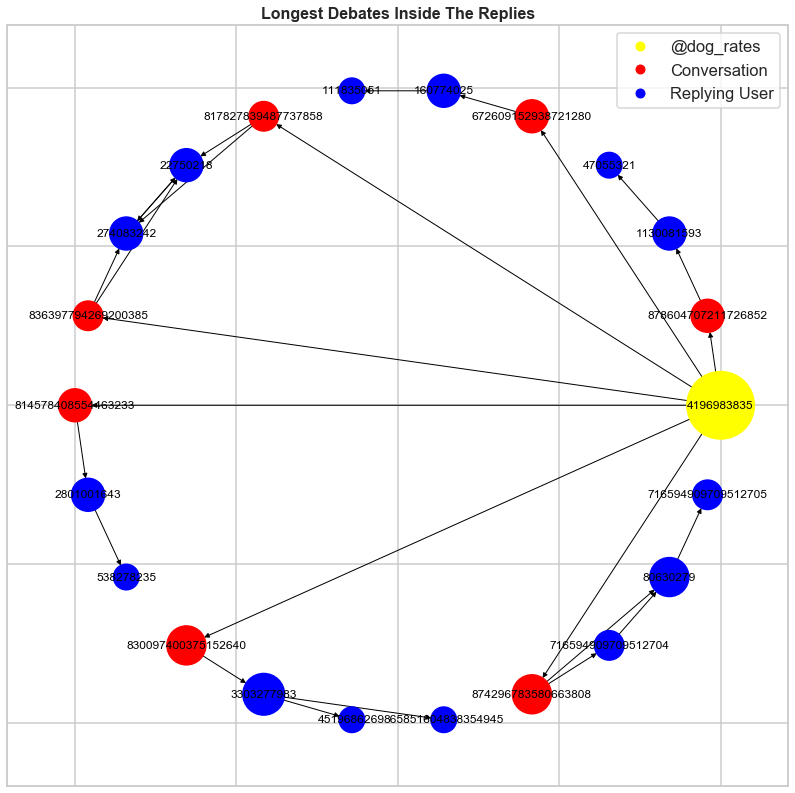

In [104]:
#It plots the graphic convfiguredd before
plt.figure(figsize=(14,14))
pos = nx.circular_layout(G_asymmetric)
plt.title('Longest Debates Inside The Replies', 
                    fontdict = {'fontsize': 16, 'fontweight': 'bold'})
nx.draw_networkx(G_asymmetric,
                 with_labels=True,
                 node_color = color_map,
                 pos = pos,
                 node_size=node_size )
custom_lines = [Line2D([0], [0], marker='o', color='yellow', lw=0),
                Line2D([0], [0], marker='o', color='red', lw=0),
                Line2D([0], [0], marker='o', color='blue', lw=0)]
plt.legend(custom_lines, ['@dog_rates', 'Conversation', 'Replying User'])
plt.savefig('pictures/social_plot.jpg')


* We are going to select two of these conversations to know about the topic of the debate.

In [105]:
#It creates a folder called pictures if it does not exists
folder_name = 'pictures'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

* First we are going to see the messages realated with the tweet `874296783580663808` and the replis of the users: `80630279`, `716594909709512705`and `716594909709512704`.

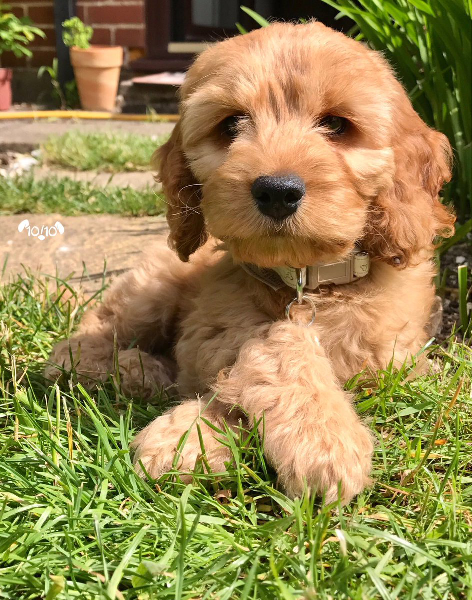

In [106]:
#Download and show the picture for conversation in tweet 874296783580663808
url = df_twitter_master_analysis[df_twitter_master_analysis['tweet_id'] == '874296783580663808']['jpg_url'].values[0]
r = requests.get(url)
with open(os.path.join(folder_name, url.split('/')[-1]), mode = 'wb') as file:
        file.write(r.content)

img = Image.open(os.path.join(folder_name, url.split('/')[-1]))
img = img.resize((int(img.size[0]/2),int(img.size[1]/2)), resample=0)
img.save('pictures/874296783580663808.jpg')
img

* It does not seem dangerous. We are going to extract the text related with this conversation.

In [107]:
#this line is to show the text not truncated
pd.set_option('display.max_colwidth', -1)
#we get the text of the tweets that we want.
list_aux = df_interactions_analysis.query\
           ('tweet_id_origin == "874296783580663808" &\
           (user_origin in ["80630279", "716594909709512705", "716594909709512704"] |\
           user_destiny in ["80630279", "716594909709512705", "716594909709512704"])')['tweet_id'].tolist()
df_scrapped_replies_analysis[df_scrapped_replies_analysis['reply_id'].isin(list_aux)]\
                            [['conversation','user_id','references','text']]

,conversation,user_id,references,text
10738,874296783580663808,80630279,['4196983835'],i notice the deck pots match his glorious coat. I'm assuming the inside of the house is just as well-coordinated
10739,874296783580663808,716594909709512704,"['80630279', '4196983835', '120854387']",My God why didn't I think of that? Life has a whole new purpose.
10740,874296783580663808,80630279,['716594909709512705'],"hah! I dont have a dog at the mo', but rather a Maine Coone cat who basically looks like a dusty Swiffer mop, so I'm good."
10741,874296783580663808,716594909709512704,['80630279'],Do you have stripy walls & very fluffy furniture? I dress all in black because
10742,874296783580663808,80630279,['716594909709512705'],"hah WoW! They're beauties and I can see why you would dress only in black.Microsuede couches, & I have a lint roller."
10743,874296783580663808,716594909709512704,['80630279'],Wow what a beauty! \r\n\r\nHave cornered the European lint roller market.
10744,874296783580663808,80630279,['716594909709512705'],"He's also very vocal but yep, he's got a good look, especially sleeping. \r\n\r\nYou're hilarious!"
10745,874296783580663808,716594909709512704,['80630279'],Does your tiger sing the Airstream Song? \r\n\r\nI would love one so much.
10746,874296783580663808,80630279,['716594909709512705'],That is so gorgeous! I am always on the lookout for one. 22ft. Maybe 1976. 1/4
10778,874296783580663808,80630279,['716594909709512705'],"oh yuk. I hadn't thought. Hopefully w/ tiny houses & such people are learning about eco-insulation, solar, off-gassing etc"




I am not very sure, but it seems that they have started to talk about other things not related with the dog.



* We can try with another conversation. For example the case that involves the tweet_it `672609152938721280` and the users `160774025` and `111835051`.

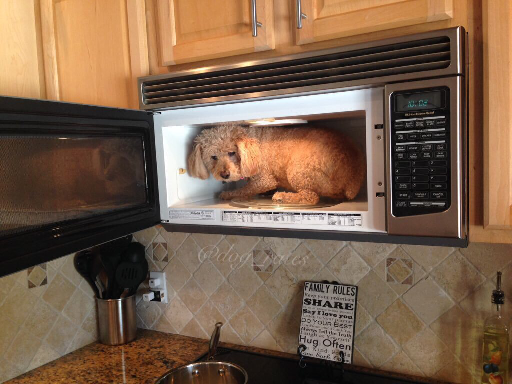

In [108]:
#Download and show the picture for conversation in tweet 672609152938721280
url = df_twitter_master_analysis[df_twitter_master_analysis['tweet_id'] == '672609152938721280']['jpg_url'].values[0]
r = requests.get(url)
with open(os.path.join(folder_name, url.split('/')[-1]), mode = 'wb') as file:
        file.write(r.content)
img = Image.open(os.path.join(folder_name, url.split('/')[-1]))
img = img.resize((int(img.size[0]/2),int(img.size[1]/2)), resample=0)
img.save('pictures/672609152938721280.jpg')
img

In [109]:
#this line is to show the text not truncated
pd.set_option('display.max_colwidth', -1)
#we get the text of the tweets that we want.
list_aux = df_interactions_analysis.query\
          ('tweet_id_origin == "672609152938721280" &\
                               (user_origin in ["160774025", "111835051"] & \
                               user_destiny in ["160774025", "111835051"])')['tweet_id'].tolist()
df_scrapped_replies_analysis[df_scrapped_replies_analysis['reply_id'].isin(list_aux)]\
                            [['conversation','user_id','references','text']]

,conversation,user_id,references,text
68860,672609152938721280,160774025,['111835051'],"Regardless, even if it was put in there, it is not in any viable danger. No harm done."
68861,672609152938721280,160774025,['111835051'],"If it wasn't on, and the baby was not in any danger of suffocation, it'd be alright. Potential harm is not the same as actual harm."
68862,672609152938721280,160774025,['111835051'],"""assault is harmful or offensive contact with a person"" If no harm is inflicted, then the definition of assault is not met."
68867,672609152938721280,160774025,['111835051'],"With that attitude, good luck with yours too. I'm having a delightful existence free of any and all assault charges and much humor."
68868,672609152938721280,160774025,['111835051'],"Implying a law degree makes you forever right in all such matters. Done arguing, I'm tired. Take care."
68875,672609152938721280,160774025,['111835051'],there's nothing wrong with if it the dog gets in there of it's own volition. Plus the door isn't shut. It can get out.
68876,672609152938721280,160774025,['111835051'],"Pretty medium sized dog, not really impossible, I've seen dogs fit into some VERY bizarre spaces."
68877,672609152938721280,160774025,['111835051'],My dog got in the back of an old CRT monitor when the back was off of it. No assistance.
68892,672609152938721280,160774025,['111835051'],"It'd be one thing if the microwave was on/closed, but it isn't. I appreciate your concern, but I think it is OK."
68912,672609152938721280,160774025,['111835051'],My brother's 80 pound greyhound can squeeze under my bed if he's determined and scared of something. Veeeeery possible.


In this case ith seems that they have started to talk about whether it is dangerous or not to put a dog inside a microwave oven. We can't see the messages from the user `111835051` because it is a private account.

<a id='analyzing_proportions'></a>
### Analysis Of The Proportions Of Dogs Detected In The Pictures

* In this part we are going to investigate how good or bad are the prediction methods. Expecifically we want to know if the methods are good to predict whether the picture is from a dog or not. To know this we are going to extract a random sample of 300 pictures and check them by ourserlves. We have decided if there is a dog in the picture or not and we have saved it in the dataframe as a boolean value. 

With this sample of 300 pictures we ar going do bootstrapping to calculate the range of proportion of dogs in all the pictures with a confidence interval of 95%.

Once done this, we can compare this values with the proportions given by the predictors.

We start merging the information about the @dog_rates tweets in `df_twitter_enhanced_analysis` and the information in `df_image_predictions_analysis` in a new dataframe `df_twitter_enhanced_predictions`.

In [110]:
df_twitter_master_analysis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2333 entries, 0 to 2332
Data columns (total 24 columns):
tweet_id                   2333 non-null object
timestamp                  2333 non-null object
source                     2333 non-null object
text                       2333 non-null object
expanded_urls              2274 non-null object
rating_numerator           2333 non-null float64
rating_denominator         2333 non-null float64
name                       2333 non-null object
replies_count              2333 non-null int64
dog_type                   1353 non-null object
retweet_count              2333 non-null float64
favorite_count             2333 non-null float64
favorites_count_retweet    2333 non-null float64
jpg_url                    2333 non-null object
img_num                    1343 non-null float64
p1                         1343 non-null object
p1_conf                    1343 non-null float64
p1_dog                     1343 non-null float64
p2                    

In [111]:
df_twitter_master_analysis.shape

(2333, 24)

In [112]:
#Read the sample in the database already categorized wiht dogs or not dogs.
df_twitter_master_sample = pd.read_sql_query("SELECT * FROM twitter_master_sample", conn)


* We have already check the 300 pictures and rated them as dog or not. So we can load the results from the database. I have decided that it is a dog if there are a dog in the pictore, even if it is very far, or there are more animals, etc. 


Anyway, behind this line I have included the code to extract te pictures, decide between dog or not and save the results in the database. It can be done directly in the notebook but it takes a litle long, so I have disabled this part of the code.

In [113]:
=========================================
Delete this if you want reevaluate the pictures
=========================================

#It takes a sample of 300 rows in df_twitter_enhanced_predictions
np.random.seed(42)
df_twitter_master_sample = df_twitter_master_analysis.query('jpg_url != ""').sample(300)

#it download the pictures of the tweets in df_twitter_master_sample and show it to you
#one by one. So you can rate each row as 'dog' or 'no dog'.

i=0
url = ''
#for each row in the dataframe
for index, row in df_twitter_master_sample.iterrows():
    url = row['jpg_url']
    #get the picture and save it in the directory folder_name
    r = requests.get(url)
    #print the url and the number of the picture.
    print(str(i) + ': ' + url)
    with open(os.path.join(folder_name, url.split('/')[-1]), mode = 'wb') as file:
        file.write(r.content)
    print(os.path.join(folder_name, url.split('/')[-1]))
    #display the picture in the notebook
    display(Image.open(os.path.join(folder_name, url.split('/')[-1])).resize((400,400), Image.ANTIALIAS))
    #It ask for an evaluation: dog or no dog.
    a = input()
    #It saves the evaluation in the dataframe.
    if a == 'y':
        df_twitter_master_sample.ix[index, 'real_dog'] = True
    else:
        df_twitter_master_sample.ix[index, 'real_dog'] = False
    i += 1




SyntaxError: invalid syntax (<ipython-input-113-bc2d24ec492c>, line 1)

In [ ]:
#It save de result in the databese DBlite
=========================================
Delete this if you want to change the file in the database.
=========================================

df_twitter_master_sample.to_sql('twitter_master_sample', conn, if_exists='replace', index=False)

* We can see that, according our decissions, the mean of dogs observed is 0.93 in this sample.

In [ ]:
#Proportion of dogs observed in the sample
df_twitter_master_sample['real_dog'].mean()

* Now we do bootstrap to extract the confidence isnterva for 95%.

In [ ]:
#we do bootstrapping with this sample
boot_means = []
for _ in range(10000):
    bootsamp = df_twitter_master_sample.sample(300, replace = True)
    boot_mean = bootsamp['real_dog'].mean()
    boot_means.append(boot_mean)
    

In [ ]:
#It plots the result above in a histogram, with 95% of confidence interval
plt.figure(figsize=(9,6))
plt.axvline(np.percentile(boot_means, 2.5), c='red')
plt.axvline(np.percentile(boot_means, 97.5), c='red')
plt.ylabel('Number Of Cases')
plt.xlabel('Proportion of Dogs')
plt.title('Distribution Of The Proportion of Dogs', 
          fontdict = {'fontsize': 16, 'fontweight': 'bold'})
sns.distplot(boot_means,kde=True, bins= 100);
plt.savefig('dist_prop.jpg')

* It seems that the proportion of pictures with dogs it is between 0.9 and 0.957 with a 95% of probabilities.

In [ ]:
#Values for proportion for a confidence interval of 95%
np.percentile(boot_means, 2.5), np.percentile(boot_means, 97.5)

* This value is much longer than the value obtained in the predictors. Even if we consider the three predictors together.

In [ ]:
#proportion of dogs in all the pictures for predictor 1
df_twitter_master_analysis['p1_dog'].mean()

In [ ]:
#proportion of dogs in all the pictures for predictor 2
df_twitter_master_analysis['p2_dog'].mean()

In [ ]:
#proportion of dogs in all the pictures for predictor 3
df_twitter_master_analysis['p3_dog'].mean()

In [ ]:
#proportion of dogs in all the pictures cosidering the sum of the three predictions.
df_twitter_master_analysis.query('(p1_dog == True | p2_dog == True | p3_dog == True)').shape[0]\
/df_twitter_master_analysis.shape[0]

* We have also tried to ivestigate which prediction method is more close to the result that we have checked by ourserlves.
To do this I have used a logistic regression of the field `real_dog` (our decissions) with the fields `p1_dog`, `p2_dog` and `p3_dog` (the prediction methods decissions).

In [ ]:
df_copy = df_twitter_master_sample.copy()
df_copy['intercept'] = 1

logit_mod = sm.Logit(df_copy['real_dog'], df_copy[['intercept','p1_dog', 'p2_dog', 'p3_dog']])
results = logit_mod.fit()
results.summary()

In [ ]:
results.params.values

In [ ]:
np.exp(results.params.values)

It seems that the p1 method is more relevant, both for coeficient and p-value. Whereas, the less relevant and with less statistical significance is the p2 method.

* We have tried to add more varibles to the logistic regression method as the number of favorites, retweets and replies.

In [114]:
df_copy = df_twitter_master_sample.copy()
df_copy['intercept'] = 1

logit_mod = sm.Logit(df_copy['real_dog'], df_copy[['intercept','p1_dog', 'p2_dog', 'p3_dog', 'favorite_count', 'retweet_count','replies_count']])
results = logit_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.161344
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               real_dog   No. Observations:                  300
Model:                          Logit   Df Residuals:                      293
Method:                           MLE   Df Model:                            6
Date:                Tue, 19 Nov 2019   Pseudo R-squ.:                  0.3639
Time:                        17:16:03   Log-Likelihood:                -48.403
converged:                       True   LL-Null:                       -76.092
Covariance Type:            nonrobust   LLR p-value:                 3.890e-10
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept         -0.3083      0.498     -0.619      0.536      -1.284       0.668
p1_dog             2.0863      0.763      2.734      0.006       0.591       3.582
p2_dog             0.8517      0.733      1.162      0.245      -0.585       2.288
p3_dog             1.4044      0.665      2.110      0.035       0.100       2.709
favorite_count     0.0001   7.18e-05      1.748      0.081   -1.52e-05       0.000
retweet_count     -0.0002      0.000     -1.177      0.239      -0.001       0.000
replies_count      0.0329      0.026      1.251      0.211      -0.019       0.085
==================================================================================
"""

In [115]:
np.exp(results.params.values)

array([0.7347277 , 8.05507691, 2.34364546, 4.07301167, 1.00012541,
       0.9997896 , 1.03348974])

The conclusion is that the probability of having a dog in the picture it grows wiht the favorites and with the replies, but decrease with the retweets.
Probably this results could be more accurate with a bigger sample.


We have also tried other combinations, but we don't have achieve any relevant conclusion.

<a id='analyzing_replies'></a>
## Analysis Of Replies Per User And Per Breed

* First, we make a merge of the dataframes with tweets data, replies and predictions.

In [116]:
#Donload again this three datasets.
df_twitter_master_analysis = pd.read_sql_query("SELECT * FROM twitter_master", conn)
df_scrapped_replies_analysis = pd.read_sql_query("SELECT * FROM scrapped_replies", conn)

In [117]:
df_complete_merge = df_twitter_master_analysis.merge(df_scrapped_replies_analysis, 
                                                       left_on='tweet_id', 
                                                       right_on='conversation', 
                                                       how = 'left')
df_complete_merge = df_complete_merge.query('jpg_url != ""')

In [118]:
df_complete_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39591 entries, 338 to 72907
Data columns (total 35 columns):
tweet_id                   39591 non-null object
timestamp_x                39591 non-null object
source                     39591 non-null object
text_x                     39591 non-null object
expanded_urls              39591 non-null object
rating_numerator           39591 non-null float64
rating_denominator         39591 non-null float64
name                       39591 non-null object
replies_count              39591 non-null int64
dog_type                   29915 non-null object
retweet_count              39591 non-null float64
favorite_count             39591 non-null float64
favorites_count_retweet    39591 non-null float64
jpg_url                    39591 non-null object
img_num                    39591 non-null float64
p1                         39591 non-null object
p1_conf                    39591 non-null float64
p1_dog                     39591 non-null float64


* One simple check is to know who are the ten users who have write more replies:

In [119]:
df1 = df_complete_merge.groupby('user_id').count().sort_values(['tweet_id'], ascending=False)['tweet_id'].head(10).reset_index()
df1 = df1.rename(columns= {'tweet_id': 'count'})
df1

,user_id,count
0,4196983835,465
1,401334573,148
2,21163853,134
3,594710756,108
4,265825342,101
5,27603608,92
6,1432492135,85
7,1337271,79
8,842618414,76
9,1417162219,67


Obviously the user `4196983835` (@dog_rates) is the one who have more replies by long.  

* We can also see that most of people (more than 75%) only have write a message in the account one or two times.

In [120]:
#we group by user and we show the detail for the column tweetid
replies_per_user = df_complete_merge.groupby('user_id').count()[['tweet_id']]
#we extract the user @dog_rates
replies_per_user = replies_per_user.query('user_id != "4196983835"')
replies_per_user.describe()

,tweet_id
count,22100.000000
mean,1.769683
std,3.265758
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,148.000000


* The breed with more replies depends on the method that we use to predict the preed. So we can see below the 10 breeds with more number of replies for each method.

In [121]:
df1 = df_complete_merge.groupby('p1').count().sort_values(['tweet_id'], ascending=False)['tweet_id'].head(10).reset_index()
df1 = df1.rename(columns= {'p1': 'p1_breed','tweet_id': 'count'})
df1

,p1_breed,count
0,golden_retriever,3940
1,Pembroke,2451
2,Labrador_retriever,1928
3,Chihuahua,1508
4,pug,1029
5,French_bulldog,909
6,Samoyed,905
7,Cardigan,813
8,cocker_spaniel,772
9,Pomeranian,712


In [122]:
df1 = df_complete_merge.groupby('p2').count().sort_values(['tweet_id'], ascending=False)['tweet_id'].head(10).reset_index()
df1 = df1.rename(columns= {'p2': 'p2_breed','tweet_id': 'count'})
df1

,p2_breed,count
0,Labrador_retriever,2897
1,Cardigan,1940
2,golden_retriever,1565
3,Pomeranian,1251
4,toy_poodle,1043
5,Chesapeake_Bay_retriever,943
6,Chihuahua,927
7,cocker_spaniel,785
8,Pembroke,755
9,Siberian_husky,721


In [123]:
df1 = df_complete_merge.groupby('p3').count().sort_values(['tweet_id'], ascending=False)['tweet_id'].head(10).reset_index()
df1 = df1.rename(columns= {'p3': 'p3_breed','tweet_id': 'count'})
df1

,p3_breed,count
0,Labrador_retriever,1550
1,Chihuahua,1191
2,kuvasz,954
3,chow,907
4,golden_retriever,878
5,Staffordshire_bullterrier,871
6,cocker_spaniel,807
7,basenji,800
8,kelpie,761
9,Eskimo_dog,745


* Finally we can see for the 5 more active users, with more replies, which breeds they preferred to comment. We can draw pie charts for each one idicating the 10 breeds of dog that have preferred reply to. In this case we use the predictions of p1 to know the breed.

In [124]:
#These are the five users with more replies. Except @dog_rates
replies_per_user_high = df_complete_merge.query('user_id != "4196983835"')
replies_per_user_high = replies_per_user_high.groupby('user_id').count().sort_values(['tweet_id'], 
                                                                                     ascending=False)['tweet_id'].head(5)
replies_per_user_high = replies_per_user_high.reset_index().rename(columns= {'tweet_id': 'Replies'})
replies_per_user_high

,user_id,Replies
0,401334573,148
1,21163853,134
2,594710756,108
3,265825342,101
4,27603608,92


In [125]:
df_most_active_users = df_complete_merge\
[(df_complete_merge.user_id.isin(replies_per_user_high.user_id))]

In [126]:
df1 = df_most_active_users.query('user_id == "401334573"').groupby(['p1']).\
                                                           count().\
                                                           sort_values(['tweet_id'],ascending=False)['tweet_id'].\
                                                           reset_index()
df2 = df_most_active_users.query('user_id == "21163853"').\
                                                           groupby(['p1']).\
                                                           count().\
                                                           sort_values(['tweet_id'],ascending=False)['tweet_id'].\
                                                           reset_index()
df3 = df_most_active_users.query('user_id == "594710756"').\
                                                           groupby(['p1']).\
                                                           count().\
                                                           sort_values(['tweet_id'],ascending=False)['tweet_id'].\
                                                           reset_index()
df4 = df_most_active_users.query('user_id == "265825342"').\
                                                           groupby(['p1']).\
                                                           count().\
                                                           sort_values(['tweet_id'],ascending=False)['tweet_id'].\
                                                           reset_index()
df5 = df_most_active_users.query('user_id == "27603608"').\
                                                           groupby(['p1']).\
                                                           count().\
                                                           sort_values(['tweet_id'],ascending=False)['tweet_id'].\
                                                           reset_index()

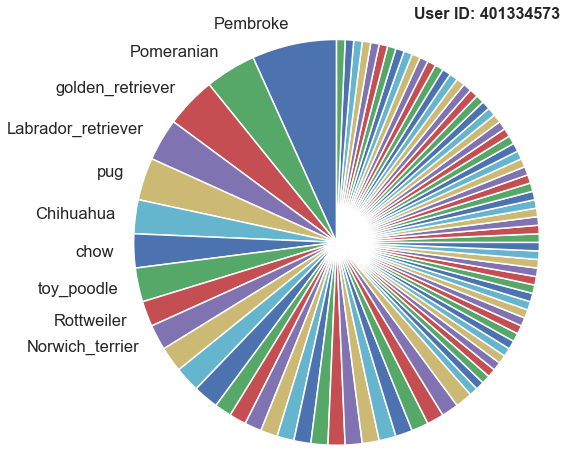

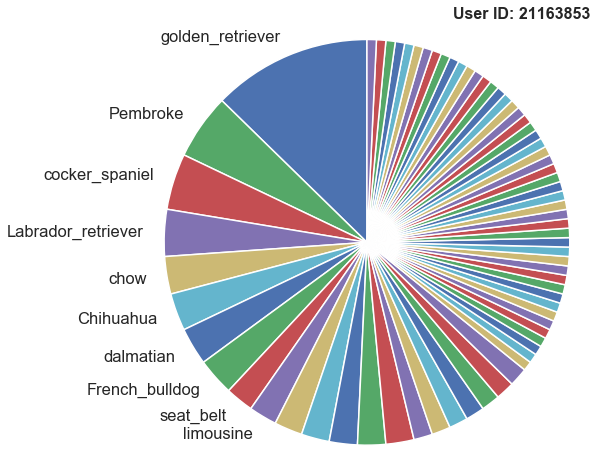

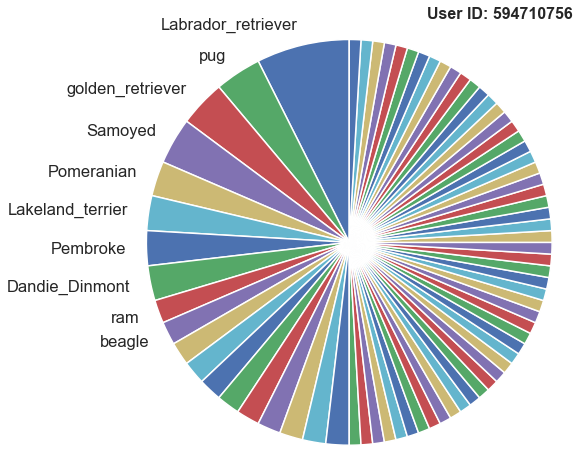

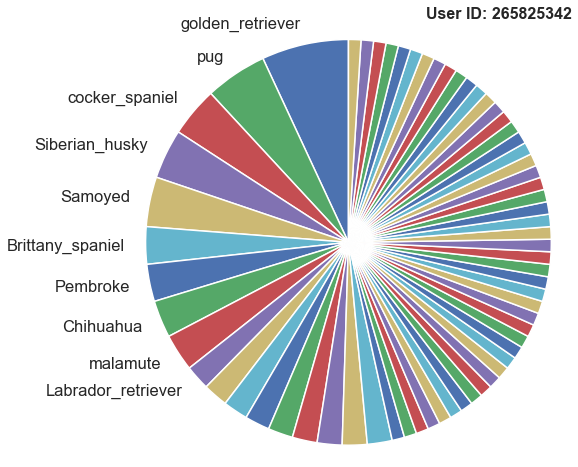

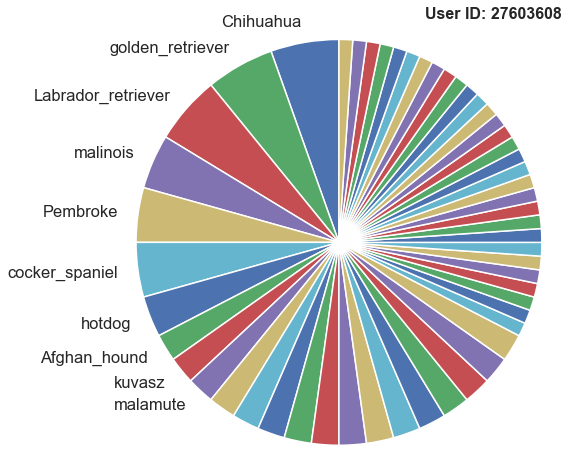

In [127]:
#Pie chart for user : 401334573
labels = df1.p1
plt.rcParams["figure.figsize"] = (8,8)
plt.title('User ID: ' + replies_per_user_high.user_id[0], 
                    fontdict = {'fontsize': 16, 'fontweight': 'bold'}, loc = 'right')
for i in range(10,len(df1.p1),1):
    labels[i]=''
sizes = df1.tweet_id

plt.pie(sizes, labels=labels, shadow=False, startangle=90)
plt.axis('equal')
plt.show();

#Pie chart for user : 21163853
labels = df2.p1
plt.rcParams["figure.figsize"] = (8,8)
plt.title('User ID: ' + replies_per_user_high.user_id[1], 
                    fontdict = {'fontsize': 16, 'fontweight': 'bold'}, loc = 'right')
for i in range(10,len(df2.p1),1):
    labels[i]=''
sizes = df2.tweet_id
plt.pie(sizes, labels=labels, shadow=False, startangle=90)
plt.axis('equal')
plt.show();

#Pie chart for user : 594710756
labels = df3.p1
plt.rcParams["figure.figsize"] = (8,8)
plt.title('User ID: ' + replies_per_user_high.user_id[2], 
                    fontdict = {'fontsize': 16, 'fontweight': 'bold'}, loc = 'right')
for i in range(10,len(df3.p1),1):
    labels[i]=''
sizes = df3.tweet_id
plt.pie(sizes, labels=labels, shadow=False, startangle=90)
plt.axis('equal') 
plt.show();

#Pie chart for user : 265825342
labels = df4.p1
plt.rcParams["figure.figsize"] = (8,8)
plt.title('User ID: ' + replies_per_user_high.user_id[3], 
                    fontdict = {'fontsize': 16, 'fontweight': 'bold'}, loc = 'right')
for i in range(10,len(df4.p1),1):
    labels[i]=''
sizes = df4.tweet_id
#fig, ax = plt.subplots()
plt.pie(sizes, labels=labels, shadow=False, startangle=90)
plt.axis('equal') 
plt.show();

#Pie chart for user : 27603608
labels = df5.p1
plt.rcParams["figure.figsize"] = (8,8)
plt.title('User ID: ' + replies_per_user_high.user_id[4], 
                    fontdict = {'fontsize': 16, 'fontweight': 'bold'}, loc = 'right')
for i in range(10,len(df5.p1),1):
    labels[i]=''
sizes = df5.tweet_id
#fig, ax = plt.subplots()
plt.pie(sizes, labels=labels, shadow=False, startangle=90)
plt.axis('equal') 

plt.show();